# Notebook for analysing all VR trials of one experimental group; 2-object forest

## For anaysis of *HC conditioning experiments*

## Assumes use of FlyOver version 9.7 or higher (closed-loop optogenetic stimulation possible)
## Data from multiple trials and flies is pooled and collected in a single data frame, which is then used for data visualisation and statistics.

In [167]:
import numpy as np
import pandas as pd 
import scipy.stats as sts
import scipy.sparse as sparse

from os import mkdir, walk, getcwd
from os.path import sep
from sys import path, exit
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors

import warnings

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

from plottingUtilities.basicPlotting import myAxisTheme,_myAccentList

from trajectoryAnalysis.trajectoryDerivedParams import relationToObject
from trajectoryAnalysis.circularStatsOnTrajectories import circmeanvec

from plottingUtilities.objectPreferencePlots import countvisits


# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto'

root = Tk()
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)


 Analysing the following folders:

['m01', 'm02', 'm03', 'm04', 'm05', 'm06', 'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18', 'm19', 'm20', 'm21', 'm22', 'm23', 'm24', 'm25']


In [184]:
# Uncomment, if you want to select a specific subset of flies (e.g. good learners..)
from operator import itemgetter
my_indices = [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24]#[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11] 
expDirs = itemgetter(*my_indices)(expDirs)

selectionTag = 'min5Visits'#'_top10'  # chose small string, to specify dataset (e.g. top5 flies)

In [185]:
%matplotlib inline 
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

analysisDir# = '/Users/haberkernh/Desktop/'

'/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/HC_x_10xChrimsonR/baseline10/antiCyli/male/analysis/'

In [186]:
try:
    mkdir(analysisDir + 'headingAnalysis')
except:
    print('Plot directory already exists')

Plot directory already exists


### Compose mutli-fly data into dataframe

In [187]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

In [188]:
expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [189]:
keylist = ['headingAngle','rotVelo','time','transVelo',
           'xPos','xPosInMiniarena','yPos','yPosInMiniarena','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','starvation','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:
        
        flyID = fileToAnalyse.split('_')[8]
        genotype = fileToAnalyse.split('_')[6]
        starvation = fileToAnalyse.split('_')[5]
        trial = FODataFiles.index(fileToAnalyse) + 1
        
        print('Loading saved *.npy file.')
        FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        if 'train' in fileToAnalyse:
            trialtype = 'train'
            rZones = 'on'
        elif 'pre' in fileToAnalyse:
            trialtype = 'pre'
            rZones = 'off'
        else:
            trialtype = 'post'
            rZones = 'off'
            
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH

        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'reinforcement', rZones)
        FODatLoad_df.insert(4, 'starvation', int(starvation[:-1]))
        FODatLoad_df.insert(5, 'moving', moving)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/HC_x_10xChrimsonR/baseline10/antiCyli/male/rawData/m01/

 Analysing the following log files:

['twoObjectForest_1cm4cmConez1_08cm3cmCyliz2R_6cmGrid_8d_5h_10xChrR-HC-Ret_10bl_m01_post_out_161126171710.txt', 'twoObjectForest_1cm4cmConez1_08cm3cmCyliz2R_6cmGrid_8d_5h_10xChrR-HC-Ret_10bl_m01_pre_out_161126164545.txt', 'twoObjectForest_1cm4cmConez1_08cm3cmCyliz2R_6cmGrid_8d_5h_10xChrR-HC-Ret_10bl_m01_train_out_161126165636.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/HC_x_10xChrimsonR/baseline10/antiCyli/male/rawData/m02/

 Analysing the following log files:

['twoObjectForest_1cm4cmConez1_08cm3cmCyliz2R_6cmGrid_8d_6h_10xChrR-HC-Ret_10bl_m02_post_out_161126181113.txt', 'twoObjectForest_1cm4cmConez1_08cm3cmCyliz2R_6cmGrid_8d_6h_10xChrR-HC-Ret_10bl_m

Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/HC_x_10xChrimsonR/baseline10/antiCyli/male/rawData/m17/

 Analysing the following log files:

['twoObjectForest_1cm4cmConez1_08cm3cmCyliz2R_6cmGrid_5-6d_8h_10xChrR-HC-Ret_10bl_m17_post_out_170201192655.txt', 'twoObjectForest_1cm4cmConez1_08cm3cmCyliz2R_6cmGrid_5-6d_8h_10xChrR-HC-Ret_10bl_m17_pre_out_170201185601.txt', 'twoObjectForest_1cm4cmConez1_08cm3cmCyliz2R_6cmGrid_5-6d_8h_10xChrR-HC-Ret_10bl_m17_train_out_170201190635.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/HC_x_10xChrimsonR/baseline10/antiCyli/male/rawData/m18/

 Analysing the following log files:

['twoObjectForest_1cm4cmConez1_08cm3cmCyliz2R_6cmGrid_5-6d_9h_10xChrR-HC-Ret_10bl_m18_post_out_170201214153.txt', 'twoObjectForest_1cm

In [190]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')
FOAllFlies_df['reinforcement'] = FOAllFlies_df['reinforcement'].astype('category')

FOAllFlies_df.head()

flyID trial trialtype reinforcement  starvation  moving  headingAngle  \
0   m01   1.0      post           off         5.0     0.0     -0.000004   
1   m01   1.0      post           off         5.0     0.0     -0.000004   
2   m01   1.0      post           off         5.0     0.0      0.011781   
3   m01   1.0      post           off         5.0     1.0      0.019635   
4   m01   1.0      post           off         5.0     1.0     -0.058905   

    rotVelo      time  transVelo       xPos  xPosInMiniarena       yPos  \
0  0.000000  0.000000   0.000000  60.622000        60.622000  35.000000   
1  0.235672  0.050005   0.793497  60.622000        60.622000  35.000000   
2  0.157064  0.100010   1.588667  60.591600        60.591600  34.974500   
3 -1.570639  0.150015   3.968839  60.531108        60.531108  34.923006   
4 -3.298343  0.200020   4.234325  60.375600        60.375600  34.799700   

   yPosInMiniarena  rEvents  
0        35.000000     10.0  
1        35.000000     10.0  
2        34.974500     10.0  
3        34.923006     10.0  
4        34.799700     10.0

In [191]:
flyIDallarray = np.asarray(FOAllFlies_df['flyID']).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))
print(flyIDs)

['m01', 'm02', 'm03', 'm04', 'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18', 'm19', 'm20', 'm21', 'm23', 'm24', 'm25']


### Define structure of trials in terms of closed-loop optogenetic stimulation and presence of landmark cues

In [192]:
# Two object reinforcement test
rZoneState = ['off','on','off']
visibilityState = ['visible','visible','visible']
groundPlane = ['texture','texture','texture']
trialName = ['pre','train','post']
gridSize = 60.0

fps = 20

In [193]:
visitRad = 15

coneCoords = [[gridSize/2, gridSize/2],
              [3*gridSize/2, -gridSize/2]]
cyliCoords = [[gridSize/2, -gridSize/2],
              [3*gridSize/2, gridSize/2]]
objCoords = [coneCoords,cyliCoords]

In [194]:
# Settings for plots

objNames = ['Cone','Cylinder']
objColors = ['mediumseagreen', 'mediumorchid']
objMarker = ['^','s']
objMarkerS = [8, 6]

objBoxColors = [['lightgreen','seagreen','mediumseagreen'],
                ['palevioletred','darkmagenta','mediumorchid']] #for spec. objects
BoxColors = ['grey','slateblue','royalblue'] # for ratio between objects

trialColors = ['darkseagreen', 'darkviolet','teal']
trialMarkers = ['d','*','o']

offsets = [1.3, 1.3, 1.3]

boxalpha = 0.5
linealpha=0.5

allTrialFigSize = (12,4)
twoTrialFigSize = (16,4)

### 2D (cartesian) residency  – check if data seemed to have loaded correctly

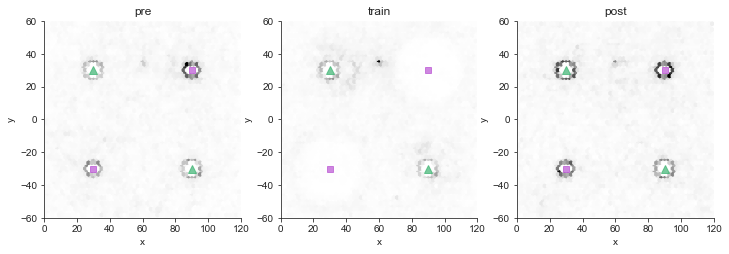

In [195]:
# plot parameter
numBins = 60

hexplotfig = plt.figure(figsize=(12,4))
for trial, condition in enumerate(trialName):
    querystring = '(trialtype == "' + condition + '") & (moving > 0)'
    xPosMA = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
    yPosMA = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
    ax = hexplotfig.add_subplot(1,len(trialName),trial+1)
    ax.hexbin(xPosMA, yPosMA, gridsize=numBins, cmap='Greys')
    plt.xlabel('x'); plt.ylabel('y')
    
    for obj in range(len(objNames)):
        ax.plot(objCoords[obj][0][0], objCoords[obj][0][1], marker=objMarker[obj], markersize=objMarkerS[obj], alpha=0.7, color=objColors[obj])
        ax.plot(objCoords[obj][1][0], objCoords[obj][1][1], marker=objMarker[obj], markersize=objMarkerS[obj], alpha=0.7, color=objColors[obj])

    ax.set_title(trialName[trial])
    ax.set_xlim(0,120)
    ax.set_ylim(-60,60)
    ax.set_aspect('equal')
    myAxisTheme(ax)

### Compute visits counts to be used as measure of learning

In [196]:
coneVisitFreq = np.zeros((len(flyIDs),len(trialName)))
cyliVisitFreq = np.zeros((len(flyIDs),len(trialName)))

coneVisitCount = np.zeros((len(flyIDs),len(trialName)))
cyliVisitCount = np.zeros((len(flyIDs),len(trialName)))

for fly in range(len(flyIDs)):
    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
        evTrial = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()

        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

        entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,timeTrial,visitRad)
        entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,timeTrial,visitRad)
        
        coneVisitFreq[fly,trial] = np.sum(entriesCone)/(timeTrial[-1]/60.0)
        cyliVisitFreq[fly,trial] = np.sum(entriesCyli)/(timeTrial[-1]/60.0)
        
        coneVisitCount[fly,trial] = np.sum(entriesCone)
        cyliVisitCount[fly,trial] = np.sum(entriesCyli)

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in minimum
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in minimum


In [197]:
# minimum amount of visits to any landmark in any trial to be considered in ananlysis
minVisit = 5

notEnoughVisits = np.where(np.sum((coneVisitCount[:,:] + cyliVisitCount[:,:])> minVisit, axis=1)<3)[0]
keepflies = list(np.where(np.sum((coneVisitCount[:,:] + cyliVisitCount[:,:])> minVisit, axis=1)>=3)[0])

print('Out of {} measured flies, {} made less than {} landmark visits in at least one of the three trials ({}%).\n').format(numFlies,
     len(notEnoughVisits), minVisit, 100*len(notEnoughVisits)/numFlies)
print('Flies that did not make enough visits:')
print(notEnoughVisits)
print('The remaining {} flies sorted according to their preference in the post trial').format(len(keepflies))
print(keepflies)

Out of 22 measured flies, 0 made less than 5 landmark visits in at least one of the three trials (0%).

Flies that did not make enough visits:
[]
The remaining 22 flies sorted according to their preference in the post trial
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


In [198]:
top10 = list(set(postPref[-11:]).intersection(set(keepflies)))
print('Selected {} flies:').format(len(top10))
print(top10)

Selected 11 flies:
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12]


## Construct data frame with relevant data in triangel tile coordinate system

In [199]:
def project2triangleTile(x, y, angle, gridSize):
    """ Function to perform projection from square tile to triangle tile. 
        
        Square tile: square zone with 120 mm side length, centered on the center of 
        the square formed by 4 landmarks.
        
        Triangle tile: triangular zone defined by one cone, one cylinder and the center of 
        the square formed by 4 landmarks. The center is positioned at (0,0) and the two 
        landmarks on the right (positive x) of the center position.
    """
    
    warnings.warn("deprecated", DeprecationWarning)
    
    slct = np.arange(0,len(x)) #~np.isnan(x)
    xt = x[slct]
    yt = y[slct]
    anglet = angle[slct]
    
    # (1) cyclic shift of big square ("miniarena")
    yt = (yt + gridSize*1.5)%(gridSize*2)
    
    # (2) cross-project top 2 squares
    leftsquare = np.logical_and(yt > gridSize, xt <= gridSize)
    rightsquare = np.logical_and(yt > gridSize, xt > gridSize)
    
    yt[leftsquare] = yt[leftsquare] - gridSize
    yt[rightsquare] = yt[rightsquare] - gridSize
    
    xt[leftsquare] = xt[leftsquare] + gridSize
    xt[rightsquare] = xt[rightsquare] - gridSize
    
    # (3) flip over the edges of the rectangle parallal to y-axis --> y unchanged, correct heading angle
    tempx = xt.copy()

    xt[tempx < gridSize/2] = abs(gridSize/2 - xt[tempx < gridSize/2]) + gridSize/2
    xt[tempx >= gridSize*1.5] = gridSize*1.5 - abs(gridSize*1.5 - xt[tempx >= gridSize*1.5])
    
    xt = xt - gridSize/2
    
    # recompute angle from flipped vector
    
    #rotate and flip, rotate back
    anglet[tempx < gridSize/2] = -(np.mod(anglet[tempx < gridSize/2] + 1.5*np.pi, 2*np.pi) - np.pi) - 0.5*np.pi
    anglet[tempx >= gridSize*1.5] = -(np.mod(anglet[tempx >= gridSize*1.5] + 1.5*np.pi, 2*np.pi) - np.pi) - 0.5*np.pi

    #correct range
    angrg = anglet < -np.pi
    anglet[np.logical_and(tempx < gridSize/2, angrg)] = \
            anglet[np.logical_and(tempx < gridSize/2, angrg)] + 2*np.pi
    anglet[np.logical_and(tempx >= gridSize*1.5, angrg)] = \
            anglet[np.logical_and(tempx >= gridSize*1.5, angrg)] + 2*np.pi
    
    
    # (4) flip lower triangle onto upper triangle (mirror along y=x diagonal)
    tempx = xt.copy()
    tempy = yt.copy()
    
    xt[tempx > tempy] = tempy[tempx > tempy]
    yt[tempx > tempy] = tempx[tempx > tempy]

    #rotate and flip, rotate back
    anglet[tempx > tempy] = -(np.mod(anglet[tempx > tempy] + 1.75*np.pi, 2*np.pi) - np.pi) - 0.75*np.pi
    
    #correct range
    anglet[np.logical_and(tempx > tempy, anglet < -np.pi)] = \
            anglet[np.logical_and(tempx > tempy, anglet < -np.pi)] + 2*np.pi
        
    
    # (5) flip upper right trianlge onto lower left triangle (mirror along y = -x + gridsize axis)
    tempx = xt.copy()
    tempy = yt.copy()
    
    xt[gridSize - tempx < tempy] = gridSize - tempy[gridSize - tempx < tempy] 
    yt[gridSize - tempx < tempy] = gridSize - tempx[gridSize - tempx < tempy]
    
    # flip parallel to x again before correcting angle
    yt = -yt + gridSize
    anglet = -anglet
    
    #rotate and flip, rotate back
    anglet[gridSize - tempx < tempy] = -(np.mod(anglet[gridSize - tempx < tempy] + 1.75*np.pi, 2*np.pi) - np.pi) - 0.75*np.pi
    
    #correct range
    anglet[np.logical_and(gridSize - tempx < tempy, anglet < -np.pi)] = \
            anglet[np.logical_and(gridSize - tempx < tempy, anglet < -np.pi)] + 2*np.pi
        
    # readjustment of triangle tile for convenience:
    xt = -xt + gridSize/2
    yt = yt - gridSize/2
    
    anglet = -(np.mod(anglet + 1.5*np.pi, 2*np.pi) - np.pi) - 0.5*np.pi

    #correct range
    angrg = anglet < -np.pi
    anglet[angrg] =  anglet[angrg] + 2*np.pi
    
    # for convenience return the coordinates for the points defining the triangle tile
    centerPos = (0,0)
    conePos = (gridSize/2,gridSize/2)
    cyliPos = (gridSize/2,-gridSize/2)
    
    return xt, yt, anglet, centerPos, conePos, cyliPos

In [200]:
#trianlge tile definition as in project2triangleTile function

# keylist of triangle tile dataframe (ttdf)
ttdf_keys = ['flyID',
             'trial',
             'rEvents',
             'moving',
             'transVelo',
             'rotVelo',
             'time',
             'x',           # raw x position 
             'y',           # raw y position
             'xt',          # x position in triangle tile
             'yt',          # y position in triangle tile
             'alphat',      # absolute heading angle in triangle tile
             'r',           # radial distance from center point (0,0)
             'gamma',       # angular position defined by r, the x-axis and the center point
             'r_cone',      # distance to cone
             'gamma_cone',  # angular position rel. to cone
             'beta_cone',   # heading angle rel. to cone (-pi,pi)
             'betah_cone',  # heading angle rel. to cone (0,pi)
             'r_cyli',      # distance to cylinder
             'gamma_cyli',  # angular position rel. to cylinder
             'beta_cyli',   # heading angle rel. to cylinder (-pi, pi)
             'betah_cyli']  # heading angle rel. to cylinder (0,pi)

In [201]:
# define empty data frame
ttdf = pd.DataFrame(data=np.zeros((0,len(ttdf_keys))), columns=ttdf_keys)

for fly in range(numFlies):

    for tind, trialtype in enumerate(trialName):
        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        subdf = FOAllFlies_df.query(querystring)
        xPosTrial = subdf['xPosInMiniarena'].values.squeeze()
        yPosTrial = subdf['yPosInMiniarena'].values.squeeze()
        headTrial = subdf['headingAngle'].values.squeeze()
        timeTrial = subdf['time'].values.squeeze()

        # Project onto triangle tile
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            xt, yt, anglet, centerPos, conePos, cyliPos = project2triangleTile(xPosTrial,yPosTrial,headTrial,gridSize)

        # Compute parameters in relation to reference landmark (relative to cone or to cylinder)
        #     distance from center
        r = np.hypot(xt,yt)

        #     angular position vector gamma
        gamma =  np.sign(yt)*(np.arccos(xt/r))

        #     distance to landmark vector: d_cyli, d_cone
        #     relative heading angle beta : bt (full range), bht (half range)
        #     radial distance r from landmarks: r_cyli = np.hypot(d_cyli[0],d_cyli[1]), r_cone = ...
        d_cyli, r_cyli, beta_cyli, betah_cyli, _ = relationToObject(timeTrial, xt, yt, anglet, cyliPos)
        d_cone, r_cone, beta_cone, betah_cone, _ = relationToObject(timeTrial, xt, yt, anglet, conePos)

        gamma_cyli =  np.arccos(d_cyli[0]/r_cyli)
        gamma_cone =  np.arccos(d_cone[0]/r_cone)

        # generate dictionary:
        ttdict = {
            'x': subdf['xPos'],
            'y': subdf['yPos'],
            'xt': xt,
            'yt': yt,      
            'alphat': anglet,
            'r': r,
            'gamma': gamma,
            'r_cone': r_cone,
            'gamma_cone': gamma_cone,
            'beta_cone': beta_cone,
            'betah_cone': betah_cone,
            'r_cyli': r_cyli,
            'gamma_cyli': gamma_cyli,
            'beta_cyli': beta_cyli,
            'betah_cyli': betah_cyli
        }
        ttdf_sub = pd.DataFrame(ttdict)
        ttdf_sub.insert(0, 'flyID', flyIDs[fly])
        ttdf_sub.insert(1, 'trial', trialtype)
        ttdf_sub = pd.concat([ttdf_sub,subdf[['moving','time','rotVelo','transVelo','rEvents']]], axis=1)
        ttdf = ttdf.append(ttdf_sub)
        
ttdf = ttdf[ttdf_keys]

In [202]:
ttdf.head()

flyID trial  rEvents  moving  transVelo   rotVelo      time          x  \
0   m01   pre     10.0     0.0   0.000000  0.000000  0.000000  60.622000   
1   m01   pre     10.0     0.0   1.229863  0.000000  0.050006  60.622000   
2   m01   pre     10.0     1.0   7.441456 -0.078455  0.100011  60.560500   
3   m01   pre     10.0     1.0   4.333868 -0.863842  0.150017  60.191640   
4   m01   pre     10.0     1.0   2.442957 -0.314124  0.200022  59.975604   

           y         xt     ...              r     gamma     r_cone  \
0  35.000000  25.000000     ...      25.007736 -0.024875  31.027518   
1  35.000000  25.000000     ...      25.007736 -0.024875  31.027518   
2  35.000000  25.000000     ...      25.006282 -0.022416  30.966824   
3  34.950893  25.049107     ...      25.049840 -0.007650  30.594877   
4  34.933725  25.066275     ...      25.066287  0.000973  30.378915   

   gamma_cone  beta_cone  betah_cone     r_cyli  gamma_cyli  beta_cyli  \
0    1.408943  -2.979736    2.979736  29.800451    1.402216  -0.168576   
1    1.408943  -2.979736    2.979736  29.800451    1.402216  -0.168576   
2    1.408623  -2.979416    2.979416  29.861081    1.402562  -0.168231   
3    1.408261  -2.975130    2.975130  30.216711    1.406208  -0.160661   
4    1.407668  -2.931340    2.931340  30.427060    1.407928  -0.115744   

   betah_cyli  
0    0.168576  
1    0.168576  
2    0.168231  
3    0.160661  
4    0.115744  

[5 rows x 22 columns]

## Distribution of heading angles as a function of ref. LM distance

In [206]:
trialTs = [10,20,10]
angleBins = 18
zonenames = ['close','mid','far','both']
ls = [':','--','-']
cols = ['steelblue','tomato']#['tomato','steelblue']#

In [207]:
tnCall = np.zeros((3,numFlies, 4, angleBins))
tnLall = np.zeros((3,numFlies, 4, angleBins))
tnCall_norm = np.zeros((3,numFlies, 4, angleBins))
tnLall_norm = np.zeros((3,numFlies, 4, angleBins))

for tind, trial in enumerate(trialName):

    for fly in range(numFlies):
        tnC = np.zeros((4, angleBins))
        tnL = np.zeros((4, angleBins))
        
        tnC_norm = np.zeros((4, angleBins))
        tnL_norm = np.zeros((4, angleBins))

        # Get data from data frame
        querystring = '(trial=="' + trial + '") & (moving>0) & (flyID == "'+flyIDs[fly]+'")'
        flyttdf = ttdf.query(querystring)

        trialT = trialTs[tind]
        rt_c = flyttdf['r_cone'].values
        rt_l = flyttdf['r_cyli'].values

        bt_c = flyttdf['beta_cone'].values
        bt_l = flyttdf['beta_cyli'].values
        # Make masks for different visibility zones for each landmark
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            close_c = np.logical_and(rt_c <= 15, rt_c > 7.5)
            mid_c = np.logical_and(rt_c > 15, rt_c <= 22.5)
            far_c = np.logical_and(rt_c > 22.5, rt_c <= 30)
            farfar_c = np.logical_and(rt_c > 30, rt_c <= 45)

            close_l = np.logical_and(rt_l <= 15, rt_l > 7.5)
            mid_l = np.logical_and(rt_l > 15, rt_l <= 22.5)
            far_l = np.logical_and(rt_l > 22.5, rt_l <= 30)
            farfar_l = np.logical_and(rt_l > 30, rt_l <= 45)
            
            both = np.logical_and(farfar_c, farfar_l)        

        selection_c = [close_c, mid_c, far_c, both]
        selection_l = [close_l, mid_l, far_l, both]
        # Compute heading maps for different zones:

        for i in range(4):
            # CONE
            n, ed = np.histogram(bt_c[selection_c[i]],bins = np.linspace(-np.pi, np.pi,angleBins+1))
            tnC[i,:] = n
            n, ed = np.histogram(bt_c[selection_c[i]],bins = np.linspace(-np.pi, np.pi,angleBins+1), density=True)
            tnC_norm[i,:] = n
            
            # CYLI
            n, ed = np.histogram(bt_l[selection_l[i]],bins = np.linspace(-np.pi, np.pi,angleBins+1))
            tnL[i,:] = n
            n, ed = np.histogram(bt_l[selection_l[i]],bins = np.linspace(-np.pi, np.pi,angleBins+1), density=True)
            tnL_norm[i,:] = n

        tnCall[tind,fly,:, :] = tnC
        tnLall[tind,fly,:, :] = tnL
        
        tnCall_norm[tind,fly,:, :] = tnC_norm
        tnLall_norm[tind,fly,:, :] = tnL_norm
        

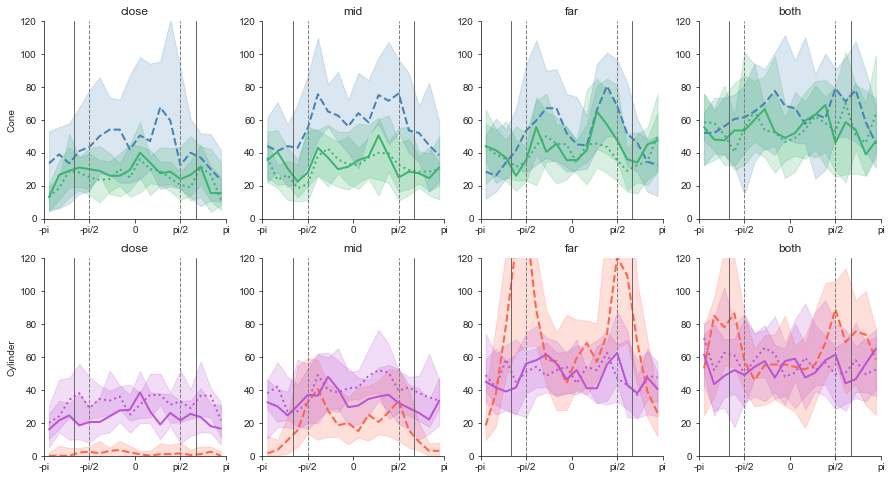

In [208]:
normHeadFig, axs = plt.subplots(2,4, figsize=(15, 8))
dat = [tnCall,tnLall]
for tind, trial in enumerate(trialName):
    for lm in range(2):
        lmax = axs[lm,:]
        for i,ax in enumerate(lmax):
            if tind==1: col = cols[lm]
            else: col = objColors[lm]
            med = np.nanmedian(dat[lm][tind,:,i,:], axis=0)
            [q25, q75] = np.nanpercentile(dat[lm][tind,:,i,:], [25, 75], axis=0)
            ax.plot(ed[1:]-np.mean(np.diff(ed[:]))/2 , med, color=col, linewidth=2, linestyle=ls[tind])
            ax.fill_between(ed[1:]-np.mean(np.diff(ed[:]))/2 , q25, q75, color=col, alpha=0.2)

for lm in range(2):
    lmax = axs[lm,:]          
    for i,ax in enumerate(lmax):
        ax.axvline(-np.pi/2, 0, 1, linestyle='dashed', color='grey', linewidth=1)
        ax.axvline(np.pi/2, 0, 1, linestyle='dashed', color='grey', linewidth=1)
        ax.axvline(-(120/180.*np.pi), 0, 1, linestyle='solid', color='dimgrey', linewidth=1)
        ax.axvline((120/180.*np.pi), 0, 1, linestyle='solid', color='dimgrey', linewidth=1)
        ax.set_title(zonenames[i])
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(0,120)
        #ax.set_yticks([0, .1, 0.2, .3, .4])
        ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
        ax.set_xticklabels(['-pi', '-pi/2', '0', 'pi/2', 'pi'])
        myAxisTheme(ax)

coneHaxs[0].legend(trialName,frameon=False,loc=1)
cyliHaxs[0].legend(trialName,frameon=False,loc=1)

axs[0,0].set_ylabel('Cone')
axs[1,0].set_ylabel('Cylinder')

coneHFig.tight_layout()
cyliHFig.tight_layout()

normHeadFig.savefig(analysisDir + 'headingAnalysis'+sep + genotype + '_' + flyIDs[0][0]
         +'_relHeadingCounts_visZones_alltrials_medIQR_bothLM_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

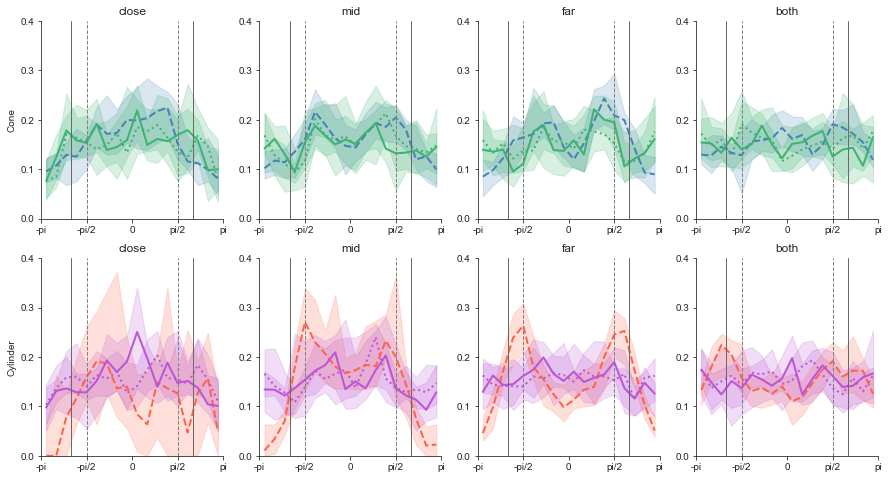

In [209]:
normHeadFig, axs = plt.subplots(2,4, figsize=(15, 8))
dat = [tnCall_norm,tnLall_norm]
for tind, trial in enumerate(trialName):
    for lm in range(2):
        lmax = axs[lm,:]
        for i,ax in enumerate(lmax):
            if tind==1: col = cols[lm]
            else: col = objColors[lm]
            med = np.nanmedian(dat[lm][tind,:,i,:], axis=0)
            [q25, q75] = np.nanpercentile(dat[lm][tind,:,i,:], [25, 75], axis=0)
            ax.plot(ed[1:]-np.mean(np.diff(ed[:]))/2 , med, color=col, linewidth=2, linestyle=ls[tind])
            ax.fill_between(ed[1:]-np.mean(np.diff(ed[:]))/2 , q25, q75, color=col, alpha=0.2)

for lm in range(2):
    lmax = axs[lm,:]          
    for i,ax in enumerate(lmax):
        ax.axvline(-np.pi/2, 0, 1, linestyle='dashed', color='grey', linewidth=1)
        ax.axvline(np.pi/2, 0, 1, linestyle='dashed', color='grey', linewidth=1)
        ax.axvline(-(120/180.*np.pi), 0, 1, linestyle='solid', color='dimgrey', linewidth=1)
        ax.axvline((120/180.*np.pi), 0, 1, linestyle='solid', color='dimgrey', linewidth=1)
        ax.set_title(zonenames[i])
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(0,.4)
        ax.set_yticks([0, .1, 0.2, .3, .4])
        ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
        ax.set_xticklabels(['-pi', '-pi/2', '0', 'pi/2', 'pi'])
        myAxisTheme(ax)

coneHaxs[0].legend(trialName,frameon=False,loc=1)
cyliHaxs[0].legend(trialName,frameon=False,loc=1)

axs[0,0].set_ylabel('Cone')
axs[1,0].set_ylabel('Cylinder')

coneHFig.tight_layout()
cyliHFig.tight_layout()

normHeadFig.savefig(analysisDir + 'headingAnalysis'+sep + genotype + '_' + flyIDs[0][0]
         +'_relHeadingFreq_visZones_alltrials_medIQR_bothLM_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

## Compare experience of headings x reinforcement in training <-> post
#### 1) Compute heading distribution of summed LM orientations experienced inside heat zone during training
#### 2) Compute heading angles at visit times in post and compare to distribution from training

In [ ]:
resdf_keylist_short = ['flyID','trial','trialtype','reinforcement','moving','time']
resdf_keylist = resdf_keylist_short + ['dist2cone','dist2cyli','closestCone', 'closestCyli']
residency_df = pd.DataFrame(data=np.zeros((0,len(resdf_keylist))), columns=resdf_keylist)

for trial, trialtype in enumerate(trialName):
    for fly in range(len(flyIDs)):

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
        
        # compute distance to each landmark
        dist2cones = np.vstack(( np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1])),
                                 np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1])) ))
        dist2cylis = np.vstack(( np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1])),
                                 np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1])) ))

        # compute distance to closest landmark
        closestCone = np.argmin(dist2cones, axis=0)
        closestCyli = np.argmin(dist2cylis, axis=0)
        
        dist2closestCone = np.min(dist2cones, axis=0)
        dist2closestCyli = np.min(dist2cylis, axis=0)
        

        tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short]
        tmpdf.insert(1,'dist2cone', dist2closestCone)
        tmpdf.insert(2,'dist2cyli', dist2closestCyli)
        
        tmpdf.insert(3,'closestCone', closestCone)
        tmpdf.insert(4,'closestCyli', closestCyli)
        
        residency_df = residency_df.append(tmpdf)

residency_df = residency_df[resdf_keylist]

TypeError: countvisits() takes exactly 3 arguments (2 given)

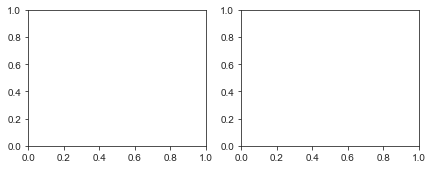

In [110]:
radExp = 25
angleBins = 12

savePlots = False

movementFilter = 'moving > 0'

keyind_dLMs = (resdf_keylist.index('dist2cone'), resdf_keylist.index('dist2cyli'))
keyind_cLMs = (resdf_keylist.index('closestCone'), resdf_keylist.index('closestCyli'))

LMcoords = [coneCoords, cyliCoords]
LMshapes = ('^','s')
LMmsize = (15,10)

trainExpHeadings = np.zeros((2, numFlies, angleBins))
postVisitHeadings = np.zeros((2, numFlies, angleBins))
preVisitHeadings = np.zeros((2, numFlies, angleBins))

trainExpHeadings_mean = np.zeros((2, numFlies, 2))
postVisitHeadings_mean = np.zeros((2, numFlies, 2))
preVisitHeadings_mean = np.zeros((2, numFlies, 2))

for fly in range(numFlies):

    fig, axs = plt.subplots(1,2,figsize=(7,2.5))

    for LM in range(len(objNames)):

        # 1) Get training experience:
        cond = trialName[1]

        querystring = '(trialtype=="' + cond + '") & (flyID=="' + flyIDs[fly] + '") & (' + movementFilter + ')'

        distLM = np.asarray(residency_df.query(querystring).iloc[:, keyind_dLMs[LM]:keyind_dLMs[LM] + 1]).squeeze()
        distLM[np.isnan(distLM)] = 100
        entries,exits,visitT,entryTime,exitTime = countvisits(distLM[distLM<=radExp],visitRad)

        closestLM = np.asarray(residency_df.query(querystring).iloc[:, keyind_cLMs[LM]:keyind_cLMs[LM] + 1]).squeeze()[distLM<=radExp]

        tLM = FOAllFlies_df.query(querystring)['time'].values.squeeze()[distLM<=radExp]
        xLM = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()[distLM<=radExp]
        yLM = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()[distLM<=radExp]
        aLM = FOAllFlies_df.query(querystring)['headingAngle'].values.squeeze()[distLM<=radExp]

        xLM[closestLM==0] = xLM[closestLM==0]-LMcoords[LM][0][0]
        yLM[closestLM==0] = yLM[closestLM==0]-LMcoords[LM][0][1]
        xLM[closestLM==1] = xLM[closestLM==1]-LMcoords[LM][1][0]
        yLM[closestLM==1] = yLM[closestLM==1]-LMcoords[LM][1][1]

        # Compute parameters in relation to reference landmark (relative to cone - c, relative to cylinder - l)
        #     distance to landmark vector: d_l = (-xt, -yt), d_c = (-xt, gridSize-yt)
        #     relative heading angle beta : bt (full range), bht (half range)
        #     radial distance r from landmarks: rt_l = np.hypot(xt,yt), rt_c = np.hypot(xt,yt-gridSize)
        dLM, rLM, bLM, bhLM, _ = relationToObject(tLM, xLM, yLM, aLM, [0,0]) 

        # Experience heading distribtion:
        n, ed = np.histogram(bLM,bins = np.linspace(-np.pi, np.pi,angleBins+1))
        trainExpHeadings[LM,fly,:] = n
        
        meandir, meanlen = circmeanvec(bLM[~np.isnan(bLM)], np.ones(len(bLM[~np.isnan(bLM)])), high=np.pi, low=-np.pi)
        trainExpHeadings_mean[LM,fly,0] = meandir
        trainExpHeadings_mean[LM,fly,1] = meanlen

        axs[LM].bar(ed[1:]-np.pi/12, n/float(sum(n)), width=(2*np.pi/angleBins), 
                        color=objColors[LM], alpha=0.5) #flyCMap.to_rgba(fly)


        # 2) Compute heading angles of visits in post
        cond = trialName[2]

        querystring = '(trialtype=="' + cond + '") & (flyID=="' + flyIDs[fly] + '") & (' + movementFilter + ')'

        distLM = np.asarray(residency_df.query(querystring).iloc[:, keyind_dLMs[LM]:keyind_dLMs[LM] + 1]).squeeze()
        distLM[np.isnan(distLM)] = 100
        entries,exits,_,_,_ = countvisits(distLM[distLM<=radExp],visitRad)

        closestLM = np.asarray(residency_df.query(querystring).iloc[:, keyind_cLMs[LM]:keyind_cLMs[LM] + 1]).squeeze()[distLM<=radExp]

        tLM = FOAllFlies_df.query(querystring)['time'].values.squeeze()[distLM<=radExp]
        xLM = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()[distLM<=radExp]
        yLM = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()[distLM<=radExp]
        aLM = FOAllFlies_df.query(querystring)['headingAngle'].values.squeeze()[distLM<=radExp]

        xLM[closestLM==0] = xLM[closestLM==0]-LMcoords[LM][0][0]
        yLM[closestLM==0] = yLM[closestLM==0]-LMcoords[LM][0][1]
        xLM[closestLM==1] = xLM[closestLM==1]-LMcoords[LM][1][0]
        yLM[closestLM==1] = yLM[closestLM==1]-LMcoords[LM][1][1]

        # Compute parameters in relation to reference landmark (relative to cone - c, relative to cylinder - l)
        #     distance to landmark vector: d_l = (-xt, -yt), d_c = (-xt, gridSize-yt)
        #     relative heading angle beta : bt (full range), bht (half range)
        #     radial distance r from landmarks: rt_l = np.hypot(xt,yt), rt_c = np.hypot(xt,yt-gridSize)
        dLM, rLM, bLM, bhLM, _ = relationToObject(tLM, xLM, yLM, aLM, [0,0])

        entryHeadings = bLM#[entries>0]

        m, ed = np.histogram(entryHeadings,bins = np.linspace(-np.pi, np.pi,angleBins+1))
        postVisitHeadings[LM,fly,:] = m
        meandir, meanlen = circmeanvec(entryHeadings[~np.isnan(entryHeadings)],
                                       np.ones(len(entryHeadings[~np.isnan(entryHeadings)])), high=np.pi, low=-np.pi)
        postVisitHeadings_mean[LM,fly,0] = meandir
        postVisitHeadings_mean[LM,fly,1] = meanlen
        
        axs[LM].plot(ed[1:]-np.pi/12, m/float(sum(m)), color=objColors[LM], alpha=1, drawstyle='steps-mid')

        
        # compute also for pre
        # 2) Compute heading angles of visits in post
        cond = trialName[0]

        querystring = '(trialtype=="' + cond + '") & (flyID=="' + flyIDs[fly] + '") & (' + movementFilter + ')'

        distLM = np.asarray(residency_df.query(querystring).iloc[:, keyind_dLMs[LM]:keyind_dLMs[LM] + 1]).squeeze()
        distLM[np.isnan(distLM)] = 100
        entries,exits,_,_,_ = countvisits(distLM[distLM<=radExp],visitRad)

        closestLM = np.asarray(residency_df.query(querystring).iloc[:, keyind_cLMs[LM]:keyind_cLMs[LM] + 1]).squeeze()[distLM<=radExp]

        tLM = FOAllFlies_df.query(querystring)['time'].values.squeeze()[distLM<=radExp]
        xLM = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()[distLM<=radExp]
        yLM = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()[distLM<=radExp]
        aLM = FOAllFlies_df.query(querystring)['headingAngle'].values.squeeze()[distLM<=radExp]

        xLM[closestLM==0] = xLM[closestLM==0]-LMcoords[LM][0][0]
        yLM[closestLM==0] = yLM[closestLM==0]-LMcoords[LM][0][1]
        xLM[closestLM==1] = xLM[closestLM==1]-LMcoords[LM][1][0]
        yLM[closestLM==1] = yLM[closestLM==1]-LMcoords[LM][1][1]

        # Compute parameters in relation to reference landmark (relative to cone - c, relative to cylinder - l)
        #     distance to landmark vector: d_l = (-xt, -yt), d_c = (-xt, gridSize-yt)
        #     relative heading angle beta : bt (full range), bht (half range)
        #     radial distance r from landmarks: rt_l = np.hypot(xt,yt), rt_c = np.hypot(xt,yt-gridSize)
        dLM, rLM, bLM, bhLM, _ = relationToObject(tLM, xLM, yLM, aLM, [0,0])

        entryHeadings = bLM#[entries>0]

        m, ed = np.histogram(entryHeadings,bins = np.linspace(-np.pi, np.pi,angleBins+1))
        preVisitHeadings[LM,fly,:] = m
        meandir, meanlen = circmeanvec(entryHeadings[~np.isnan(entryHeadings)],
                                       np.ones(len(entryHeadings[~np.isnan(entryHeadings)])), high=np.pi, low=-np.pi)
        preVisitHeadings_mean[LM,fly,0] = meandir
        preVisitHeadings_mean[LM,fly,1] = meanlen
        
        axs[LM].plot(ed[1:]-np.pi/12, m/float(sum(m)), color=objColors[LM], alpha=0.7, linestyle='--', 
                     drawstyle='steps-mid')


        axs[LM].set_xlim(-np.pi,np.pi)
        axs[LM].set_title(objNames[LM])
        myAxisTheme(axs[LM])
                
        if savePlots:
            fig.savefig(analysisDir + 'headingAnalysis'+sep + genotype + '_' + flyIDs[0][0]
             +'_headingInZone_train-post_expRadius'+str(radExp)+'mm_'+flyIDs[fly]+'.pdf', format='pdf')

#### 3) Across flies compare difference in the two distributions

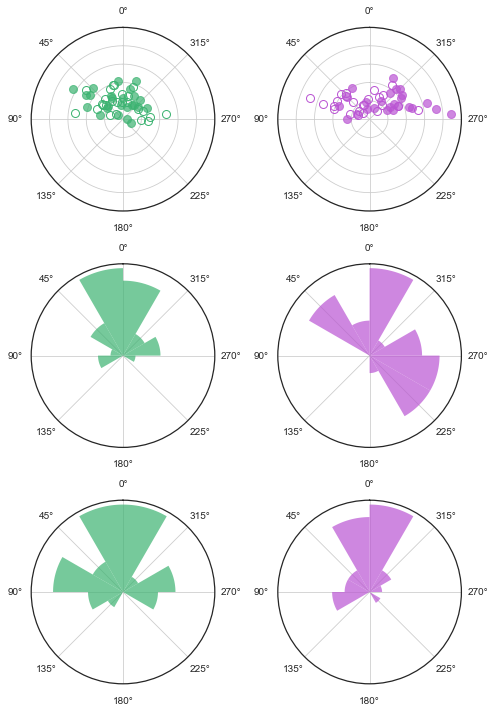

In [525]:
fig, axs = plt.subplots(3,2,figsize=(7,10), subplot_kw=dict(projection='polar'))

for LM in range(len(objNames)):
    axs[0,LM].plot(trainExpHeadings_mean[LM,:,0],trainExpHeadings_mean[LM,:,1],'o', color=objColors[LM], alpha=0.7, 
                   markersize=8)
    axs[0,LM].plot(postVisitHeadings_mean[LM,:,0],postVisitHeadings_mean[LM,:,1],'o', markeredgecolor=objColors[LM],
                 markerfacecolor='none', alpha=1, markersize=8)
    axs[0,LM].set_rlim(0, 1)
    axs[0,LM].set_theta_zero_location("N")
    axs[0,LM].set_yticklabels([])
    
    axs[1,LM].hist(trainExpHeadings_mean[LM,:,0]-postVisitHeadings_mean[LM,:,0], color=objColors[LM], alpha=0.7,
                  bins=angleBins,range=(-np.pi, np.pi))
    #axs[1,LM].set_rlim(0, 1.5)
    axs[1,LM].set_theta_zero_location("N")
    axs[1,LM].set_yticks([])
    
    axs[2,LM].hist(preVisitHeadings_mean[LM,:,0]-postVisitHeadings_mean[LM,:,0], color=objColors[LM], alpha=0.7,
                  bins=angleBins,range=(-np.pi, np.pi))
    axs[2,LM].set_theta_zero_location("N")
    axs[2,LM].set_yticks([])
    
fig.tight_layout()


fig.savefig(analysisDir + 'headingAnalysis'+sep + genotype + '_' + flyIDs[0][0]
         +'_avRelHeadingInZone_train-post_expRadius'+str(radExp)+'mm_n'+ str(len(flyIDs)) +selectionTag+'_v2.pdf', format='pdf')

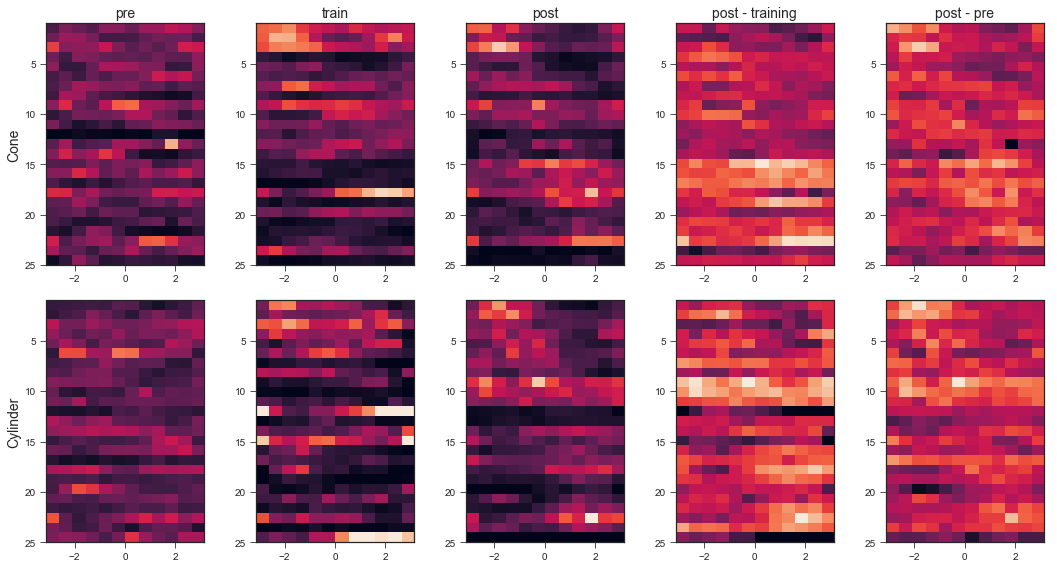

In [526]:
fig, axs = plt.subplots(2,5,figsize=(15,8))

postPref = list(np.argsort(coneVisitCount[:,2]-cyliVisitCount[:,2]))

for LM in range(len(objNames)):
    sortList = list(np.argsort(postVisitHeadings_mean[LM,:,0]))
    #sortList = np.copy(postPref)
    
    preDistr = np.squeeze(preVisitHeadings[LM,sortList,:])/np.sum(preVisitHeadings[LM,sortList,:], axis=0)
    trainDistr = np.squeeze(trainExpHeadings[LM,sortList,:])/np.sum(trainExpHeadings[LM,sortList,:], axis=0)
    postDistr = np.squeeze(postVisitHeadings[LM,sortList,:])/np.sum(postVisitHeadings[LM,sortList,:], axis=0)
    
    axs[LM,0].imshow(preDistr,extent=[-np.pi, np.pi,25,1], aspect=0.4, vmin=0, vmax=0.15)
    axs[LM,0].set_ylabel(objNames[LM], fontsize=14)

    axs[LM,1].imshow(trainDistr, extent=[-np.pi, np.pi,25,1], aspect=0.4, vmin=0, vmax=0.15)
    axs[LM,2].imshow(postDistr, extent=[-np.pi, np.pi,25,1], aspect=0.4,vmin=0, vmax=0.15)
    
    axs[LM,3].imshow(postDistr - trainDistr,
                     extent=[-np.pi, np.pi,25,1], aspect=0.4, vmin=-.1, vmax=.1)
    axs[LM,4].imshow(postDistr - preDistr,
                     extent=[-np.pi, np.pi,25,1], aspect=0.4, vmin=-.1, vmax=.1)

for tind,trial in enumerate(trialName):
    axs[0,tind].set_title(trial, fontsize=14)
axs[0,3].set_title('post - training', fontsize=14)
axs[0,4].set_title('post - pre', fontsize=14)

fig.tight_layout()


fig.savefig(analysisDir + 'headingAnalysis'+sep + genotype + '_' + flyIDs[0][0]
         +'_relHeadingInZone_trialComps_expRadius'+str(radExp)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

(0.38865850103415139, 0.054849490959300064)
(0.30887353747671842, 0.13301576638835469)


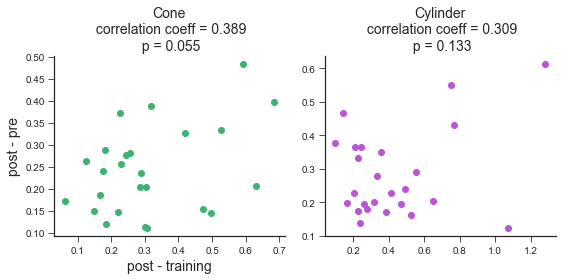

In [527]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

postPref = list(np.argsort(coneVisitCount[:,2]-cyliVisitCount[:,2]))

for LM in range(len(objNames)):
    preDistr = np.squeeze(preVisitHeadings[LM,:,:])/np.sum(preVisitHeadings[LM,:,:], axis=0)
    trainDistr = np.squeeze(trainExpHeadings[LM,:,:])/np.sum(trainExpHeadings[LM,:,:], axis=0)
    postDistr = np.squeeze(postVisitHeadings[LM,:,:])/np.sum(postVisitHeadings[LM,:,:], axis=0)
        
    axs[LM].plot(np.sum(abs(postDistr-trainDistr),axis=1), 
                   np.sum(abs(postDistr-preDistr),axis=1),'o',color=objColors[LM])
    
    cc, pp = sts.pearsonr(np.sum(abs(postDistr-trainDistr),axis=1),np.sum(abs(postDistr-preDistr),axis=1))
    print(cc,pp)
    axs[LM].set_title(objNames[LM]+'\n correlation coeff = '+str(np.round(cc, 3))+'\n p = '+str(np.round(pp, 3)), fontsize=14)
    myAxisTheme(axs[LM])
            
axs[0].set_xlabel('post - training', fontsize=14)
axs[0].set_ylabel('post - pre', fontsize=14)

fig.tight_layout()

fig.savefig(analysisDir + 'headingAnalysis'+sep + genotype + '_' + flyIDs[0][0]
         +'_distrDifferenceCorrelations_expRadius'+str(radExp)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

(0.38865850103415139, 0.054849490959300064)
(0.30887353747671842, 0.13301576638835469)


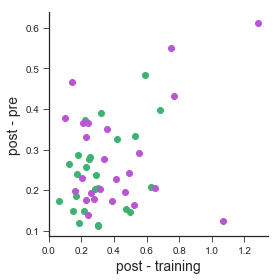

In [528]:
fig, axs = plt.subplots(1,1,figsize=(4,4))

postPref = list(np.argsort(coneVisitCount[:,2]-cyliVisitCount[:,2]))

for LM in range(len(objNames)):
    preDistr = np.squeeze(preVisitHeadings[LM,:,:])/np.sum(preVisitHeadings[LM,:,:], axis=0)
    trainDistr = np.squeeze(trainExpHeadings[LM,:,:])/np.sum(trainExpHeadings[LM,:,:], axis=0)
    postDistr = np.squeeze(postVisitHeadings[LM,:,:])/np.sum(postVisitHeadings[LM,:,:], axis=0)
        
    axs.plot(np.sum(abs(postDistr-trainDistr),axis=1), 
                   np.sum(abs(postDistr-preDistr),axis=1),'o',color=objColors[LM])
    
    cc, pp = sts.pearsonr(np.sum(abs(postDistr-trainDistr),axis=1),np.sum(abs(postDistr-preDistr),axis=1))
    print(cc,pp)
    myAxisTheme(axs)
            
axs.set_xlabel('post - training', fontsize=14)
axs.set_ylabel('post - pre', fontsize=14)

fig.tight_layout()

fig.savefig(analysisDir + 'headingAnalysis'+sep + genotype + '_' + flyIDs[0][0]
         +'_distrDifferenceCorrelations_expRadius'+str(radExp)+'mm_n'+ str(len(flyIDs)) +selectionTag+'_v2.pdf', format='pdf')

## Analyze turn behavior

In [303]:
ttdf.head()

flyID trial  rEvents  moving  transVelo   rotVelo      time          x  \
0   m01   pre     10.0     0.0   0.000000  0.000000  0.000000  60.622000   
1   m01   pre     10.0     0.0   1.229863  0.000000  0.050006  60.622000   
2   m01   pre     10.0     1.0   7.441456 -0.078455  0.100011  60.560500   
3   m01   pre     10.0     1.0   4.333868 -0.863842  0.150017  60.191640   
4   m01   pre     10.0     1.0   2.442957 -0.314124  0.200022  59.975604   

           y         xt        yt    alphat          r     gamma     r_cone  \
0  35.000000  25.000000 -0.622000 -1.570793  25.007736 -0.024875  31.027518   
1  35.000000  25.000000 -0.622000 -1.570793  25.007736 -0.024875  31.027518   
2  35.000000  25.000000 -0.560500 -1.570793  25.006282 -0.022416  30.966824   
3  34.950893  25.049107 -0.191640 -1.566869  25.049840 -0.007650  30.594877   
4  34.933725  25.066275  0.024396 -1.523672  25.066287  0.000973  30.378915   

   gamma_cone  beta_cone     r_cyli  gamma_cyli  beta_cyli  
0    1.408943   2.979736  29.800451    1.402216   0.168576  
1    1.408943   2.979736  29.800451    1.402216   0.168576  
2    1.408623   2.979416  29.861081    1.402562   0.168231  
3    1.408261   2.975130  30.216711    1.406208   0.160661  
4    1.407668   2.931340  30.427060    1.407928   0.115744

### Generate data frames for good and bad learners

In [304]:
learning = coneVisitCount[:,2] - cyliVisitCount[:,2]
print(learning)

[  5.  -8.   8.   5. -15.   6.   1.   4.  -4.   9.   1.   0.   6.   9.   1.
  -1.  12.  -3.  -1.  -2.  -1.   1.   9.   0.  -5.]


In [305]:
goodLearnDf = pd.DataFrame()
badLearnDf = pd.DataFrame()

for fly in range(numFlies):
    flyttdf = ttdf.query('flyID=="'+flyIDs[fly]+'"')

    if learning[fly] > np.median(learning):
        goodLearnDf = goodLearnDf.append(flyttdf)
    else:
        badLearnDf = badLearnDf.append(flyttdf)

### Rotational velocity ~ Translational velocity
#### All flies

Text(0,0.5,u'in baseline zone')

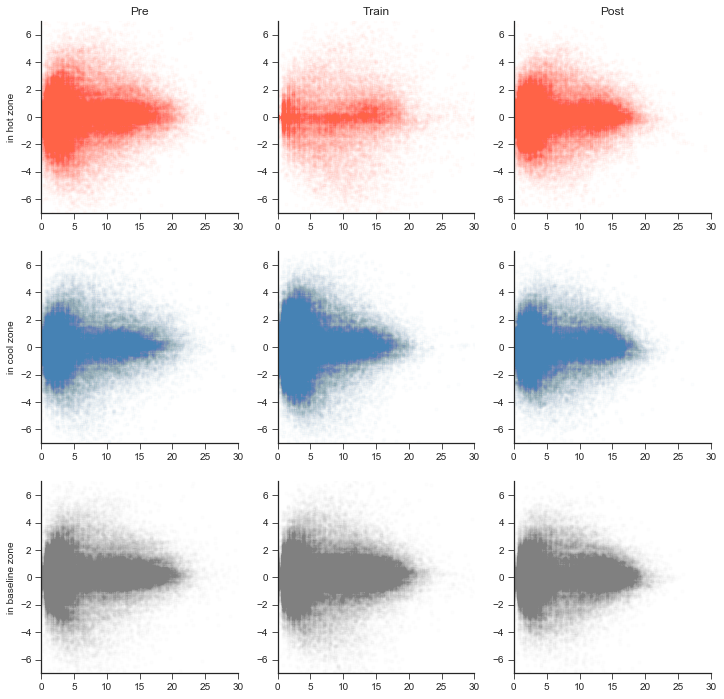

In [30]:
maxRdist = 25

range_vtr = [ [-7, 7], [0, 30]]
extent_vtr = [0, 30, -7, 7]

histStat = 'mean'
numBins = [24,28]

headfig, headaxs = plt.subplots(3,3,figsize=(12,12))
for tind, trial in enumerate(trialName):
    flyttdf = ttdf.query('trial=="'+trial+'" & r_cyli<='+str(maxRdist)+'& transVelo>'+str(0))
    headaxs[0,tind].plot(flyttdf['transVelo'], flyttdf['rotVelo'],'.', alpha=0.01, color='tomato')
    
    flyttdf = ttdf.query('trial=="'+trial+'" & r_cone<='+str(maxRdist)+'& transVelo>'+str(0))
    headaxs[1,tind].plot(flyttdf['transVelo'], flyttdf['rotVelo'],'.', alpha=0.01,color='steelblue')
        
    flyttdf = ttdf.query('trial=="'+trial+'"'+' & r_cone>'+str(maxRdist)+' & r_cyli>'+str(maxRdist)+' & transVelo>'+str(0))
    headaxs[2,tind].plot(flyttdf['transVelo'], flyttdf['rotVelo'],'.', alpha=0.01, color='grey')

    for i in range(3):
        myAxisTheme(headaxs[i,tind])
        headaxs[i,tind].set_xlim(0, 30)
        headaxs[i,tind].set_ylim(-7, 7)
        headaxs[0,tind].set_title(trialName[tind].capitalize(), fontsize=12)
        
headaxs[0,0].set_ylabel('in hot zone')
headaxs[1,0].set_ylabel('in cool zone')
headaxs[2,0].set_ylabel('in baseline zone')

Text(0,0.5,u'in baseline zone')

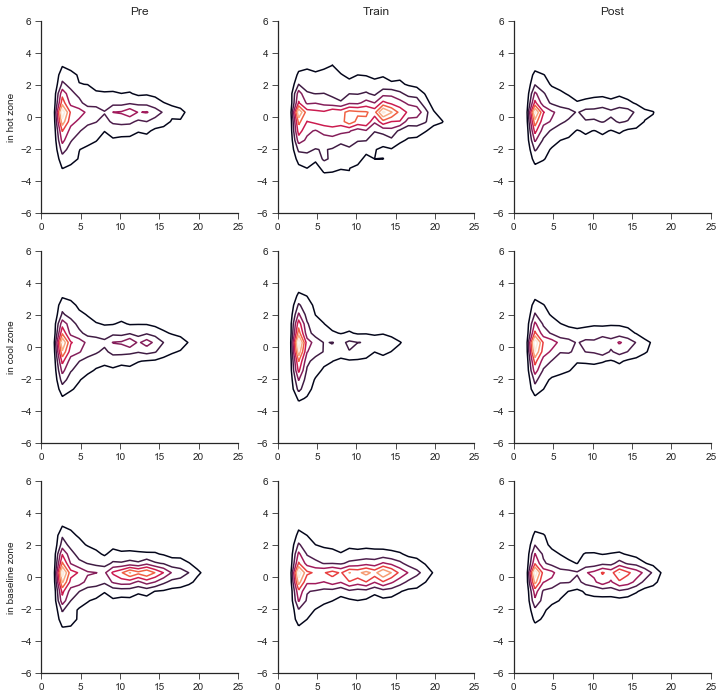

In [34]:
maxRdist = 25

vtTH = 2

range_vtr = [ [-7, 7], [0, 30]]
extent_vtr = [0, 30, -7, 7]

numBins = [24,28]

headfig, headaxs = plt.subplots(3,3,figsize=(12,12))
for tind, trial in enumerate(trialName):
    flyttdf = ttdf.query('trial=="'+trial+'" & r_cyli<='+str(maxRdist)+'& transVelo>='+str(vtTH))
    
    H, xedg, yedg = np.histogram2d(flyttdf['rotVelo'],flyttdf['transVelo'], bins=numBins, range=range_vtr)
    #map2d = headaxs[0,tind].imshow(H, cmap='Greys', extent=extent_vtr, interpolation='nearest', 
    #                                 origin='lower', aspect=2)
    X, Y = np.meshgrid(yedg[:-1]+np.diff(yedg[:2])/2,xedg[:-1]+np.diff(xedg[:2])/2)
    CS = headaxs[0,tind].contour(X, Y, H)
    #plt.clabel(CS, inline=1, fontsize=8)
    
    flyttdf = ttdf.query('trial=="'+trial+'" & r_cone<='+str(maxRdist)+'& transVelo>='+str(vtTH))
    
    H, xedg, yedg = np.histogram2d(flyttdf['rotVelo'],flyttdf['transVelo'], bins=numBins, range=range_vtr)
    X, Y = np.meshgrid(yedg[:-1]+np.diff(yedg[:2])/2,xedg[:-1]+np.diff(xedg[:2])/2)
    CS = headaxs[1,tind].contour(X, Y, H)
            
    flyttdf = ttdf.query('trial=="'+trial+'" & r_cone>'+str(maxRdist)+'& r_cyli>'+str(maxRdist)+'& transVelo>='+str(vtTH))
    
    H, xedg, yedg = np.histogram2d(flyttdf['rotVelo'],flyttdf['transVelo'],bins=numBins, range=range_vtr)
    X, Y = np.meshgrid(yedg[:-1]+np.diff(yedg[:2])/2,xedg[:-1]+np.diff(xedg[:2])/2)
    CS = headaxs[2,tind].contour(X, Y, H)

    for i in range(3):
        myAxisTheme(headaxs[i,tind])
        headaxs[i,tind].set_xlim(0, 25)
        headaxs[i,tind].set_ylim(-6,6)
        headaxs[0,tind].set_title(trialName[tind].capitalize(), fontsize=12)
        
headaxs[0,0].set_ylabel('in hot zone')
headaxs[1,0].set_ylabel('in cool zone')
headaxs[2,0].set_ylabel('in baseline zone')

#### single fly

In [37]:
fly = 16

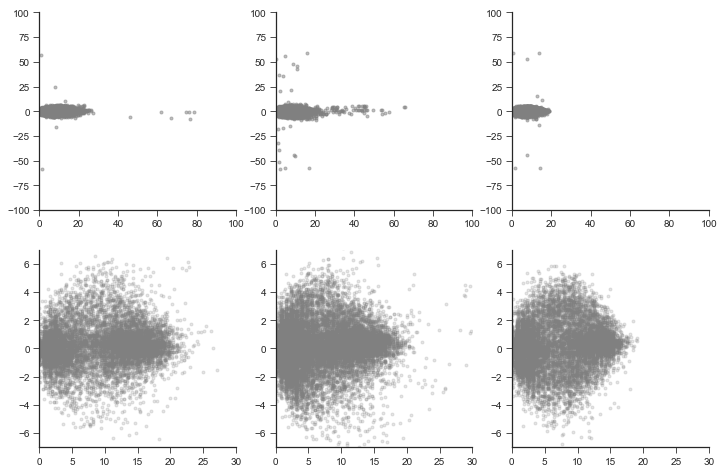

In [38]:
maxRdist = 100
headfig, headaxs = plt.subplots(2,3,figsize=(12,8))
for tind, trial in enumerate(trialName):
    flyttdf = ttdf.query('trial=="'+trial+'" & r_cyli<='+str(maxRdist)+' & flyID=="'+flyIDs[fly]+'"')
    
    headaxs[0,tind].plot(flyttdf['transVelo'], flyttdf['rotVelo'],'.', alpha=0.5,color='grey')
    headaxs[0,tind].set_xlim(0, 100)
    headaxs[0,tind].set_ylim(-100, 100)
    myAxisTheme(headaxs[0,tind])
    
    headaxs[1,tind].plot(flyttdf['transVelo'], flyttdf['rotVelo'],'.', alpha=0.2,color='grey')
    headaxs[1,tind].set_xlim(0, 30)
    headaxs[1,tind].set_ylim(-7, 7)
    myAxisTheme(headaxs[1,tind])

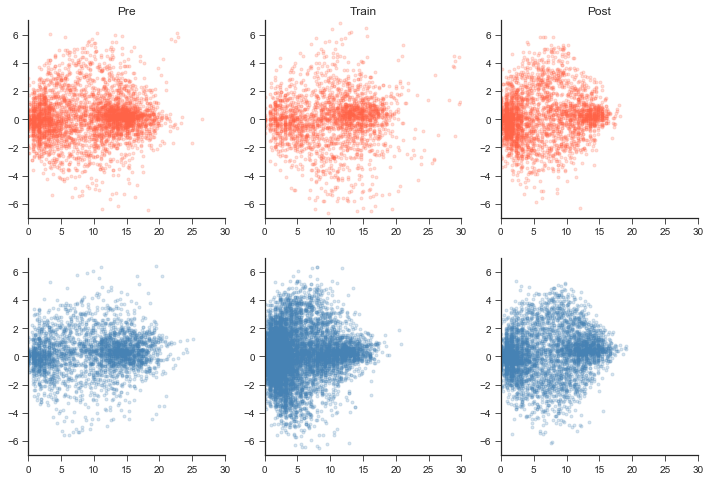

In [39]:
maxRdist = 25
headfig, headaxs = plt.subplots(2,3,figsize=(12,8))
for tind, trial in enumerate(trialName):
    flyttdf = ttdf.query('trial=="'+trial+'" & r_cyli<='+str(maxRdist)+' & flyID=="'+flyIDs[fly]+'"')
    headaxs[0,tind].plot(flyttdf['transVelo'], flyttdf['rotVelo'],'.', alpha=0.2, color='tomato')

    flyttdf = ttdf.query('trial=="'+trial+'" & r_cone<='+str(maxRdist)+' & flyID=="'+flyIDs[fly]+'"')
    headaxs[1,tind].plot(flyttdf['transVelo'], flyttdf['rotVelo'],'.', alpha=0.2,color='steelblue')
    
    for i in range(2):
        myAxisTheme(headaxs[i,tind])
        headaxs[i,tind].set_xlim(0, 30)
        headaxs[i,tind].set_ylim(-7,7)
        headaxs[0,tind].set_title(trialName[tind].capitalize(), fontsize=12)

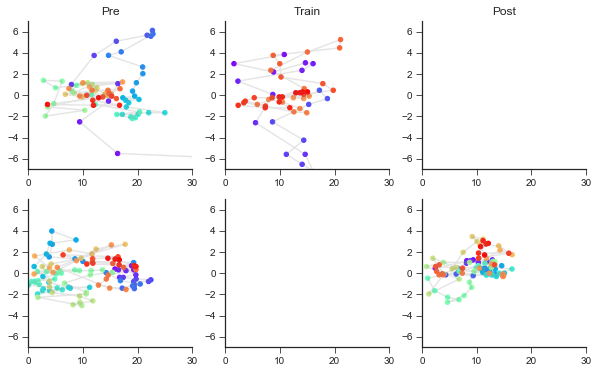

In [40]:
maxRdist = 25
headfig, headaxs = plt.subplots(2,3,figsize=(10,6))
for tind, trial in enumerate(trialName):
    flyttdf = ttdf.query('trial=="'+trial+'" & r_cyli<='+str(maxRdist)+' & flyID=="'+flyIDs[fly]+'" & time<'+str(10)+'')
    headaxs[0,tind].plot(flyttdf['transVelo'], flyttdf['rotVelo'],'-', alpha=0.2, color='grey')
    headaxs[0,tind].scatter(flyttdf['transVelo'], flyttdf['rotVelo'], s=20, c=flyttdf['time'],cmap='rainbow')
    
    flyttdf = ttdf.query('trial=="'+trial+'" & r_cone<='+str(maxRdist)+' & flyID=="'+flyIDs[fly]+'" & time<'+str(10)+'')    
    headaxs[1,tind].plot(flyttdf['transVelo'], flyttdf['rotVelo'],'-', alpha=0.2,color='grey')
    headaxs[1,tind].scatter(flyttdf['transVelo'], flyttdf['rotVelo'], s=20, c=flyttdf['time'], cmap='rainbow')

    for i in range(2):
        myAxisTheme(headaxs[i,tind])
        headaxs[i,tind].set_xlim(0, 30)
        headaxs[i,tind].set_ylim(-7,7)
        headaxs[0,tind].set_title(trialName[tind].capitalize(), fontsize=12)

### Location of turn events
#### Single fly

In [79]:
rotTH = 1
moveTH = 7
fly = 16

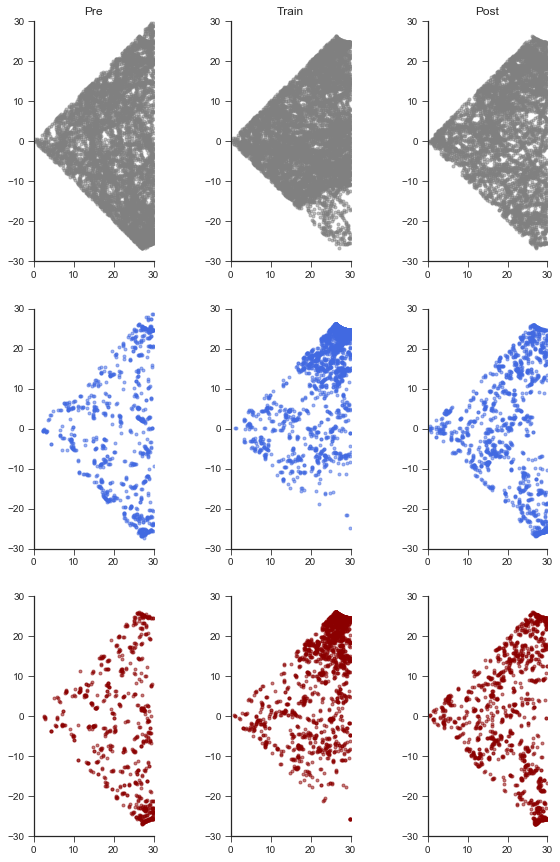

In [49]:
headfig, headaxs = plt.subplots(3,3,figsize=(10,15))
for tind, trial in enumerate(trialName):
    
    # movement points
    flyttdf = ttdf.query('trial=="'+trial+'" '+' & flyID=="'+flyIDs[fly]+'" & transVelo>'+str(moveTH)+'')
    headaxs[0,tind].plot(flyttdf['xt'], flyttdf['yt'],'.', alpha=0.5, color='grey')
    
    # cw rot points
    flyttdf = ttdf.query('trial=="'+trial+'" '+' & flyID=="'+flyIDs[fly]+
                         '" & transVelo<='+str(moveTH)+' & rotVelo>'+str(rotTH)+'')
    headaxs[1,tind].plot(flyttdf['xt'], flyttdf['yt'],'.', alpha=0.5, color='royalblue')
    
    # ccw rot points
    flyttdf = ttdf.query('trial=="'+trial+'" '+' & flyID=="'+flyIDs[fly]+\
                         '" & transVelo<='+str(moveTH)+' & rotVelo<'+str(-rotTH)+'')
    headaxs[2,tind].plot(flyttdf['xt'], flyttdf['yt'],'.', alpha=0.5, color='darkred')
    
    for i in range(3):
        myAxisTheme(headaxs[i,tind])
        headaxs[i,tind].set_xlim(0, 30)
        headaxs[i,tind].set_ylim(-30,30)
        headaxs[i,tind].set_aspect('equal')
        headaxs[0,tind].set_title(trialName[tind].capitalize(), fontsize=12)

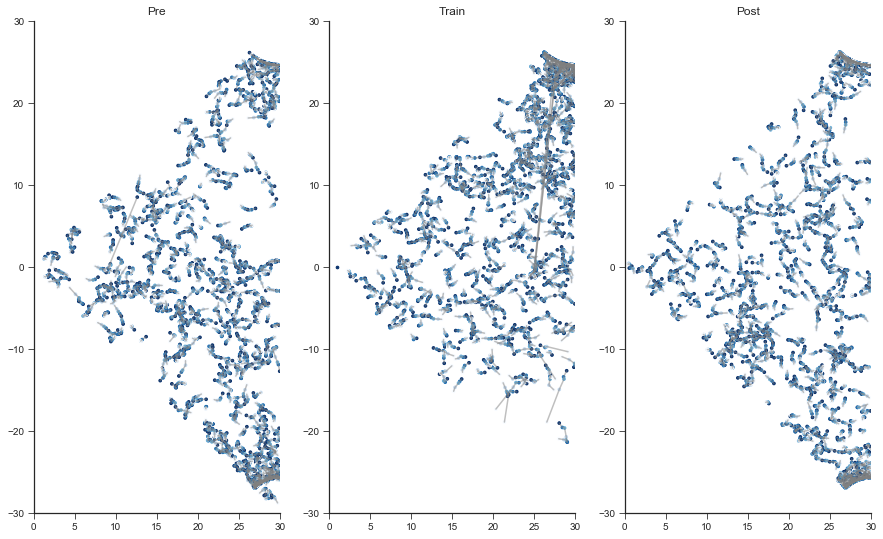

In [98]:
dt = 5
headfig, headaxs = plt.subplots(1,3,figsize=(15,10))

for tind, trial in enumerate(trialName):
    querystring = 'trial=="'+trial+'" & flyID=="'+flyIDs[fly]+'"'
    
    flyttdf = ttdf.query(querystring)

    vRot = flyttdf['rotVelo'].values
    vTrans = flyttdf['transVelo'].values

    turnEvents = np.logical_and(abs(vRot)>rotTH, vTrans<moveTH).astype('int')

    startTE = np.where(np.diff(turnEvents)==1)[0]

    for i in startTE:
        headaxs[tind].plot(flyttdf['xt'].values[i:i+dt], flyttdf['yt'].values[i:i+dt],'-', alpha=0.5, color='grey')
        headaxs[tind].scatter(flyttdf['xt'].values[i:i+dt], flyttdf['yt'].values[i:i+dt],s=7,\
                              c=flyttdf['time'].values[i:i+dt], cmap='Blues_r')

    myAxisTheme(headaxs[tind])
    headaxs[tind].set_xlim(0, 30)
    headaxs[tind].set_ylim(-30,30)
    headaxs[tind].set_aspect('equal')
    headaxs[tind].set_title(trialName[tind].capitalize(), fontsize=12)

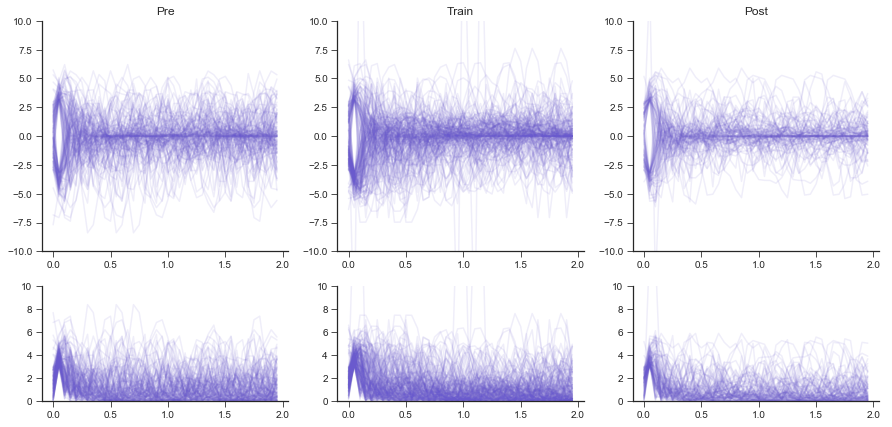

In [310]:
dtpr = 0
dtpo = 40

fly = 5

headfig, headaxs = plt.subplots(2,3,figsize=(15,7),gridspec_kw={'height_ratios':[2,1]})

for tind, trial in enumerate(trialName):
    querystring = 'trial=="'+trial+'" & flyID=="'+flyIDs[fly]+'"'
    
    flyttdf = ttdf.query(querystring)

    vRot = flyttdf['rotVelo'].values
    vTrans = flyttdf['transVelo'].values
    
    rCone = flyttdf['r_cone'].values
    rCyli = flyttdf['r_cyli'].values

    turnEvents = np.logical_and(abs(vRot)>rotTH, vTrans<moveTH).astype('int')

    startTE = np.where(np.diff(turnEvents[dtpr:-dtpo])==1)[0]

    for i in startTE:
        if flyttdf['r_cone'].values[i]<maxRdist or flyttdf['r_cyli'].values[i]<maxRdist:
            continue
        
        headaxs[0,tind].plot(flyttdf['time'].values[i-dtpr:i+dtpo]-flyttdf['time'].values[i],\
                           flyttdf['rotVelo'].values[i-dtpr:i+dtpo],'-',\
                           alpha=0.05, color='slateblue')
        
        headaxs[1,tind].plot(flyttdf['time'].values[i-dtpr:i+dtpo]-flyttdf['time'].values[i],\
                           abs(flyttdf['rotVelo'].values[i-dtpr:i+dtpo]),'-',\
                           alpha=0.05, color='slateblue')

    for i in range(2):
        myAxisTheme(headaxs[i,tind])
    headaxs[0,tind].set_ylim(-10,10)
    headaxs[0,tind].set_title(trialName[tind].capitalize(), fontsize=12)
    headaxs[1,tind].set_ylim(-0,10)

#### all flies

In [69]:
rotTH = 1
moveTH = 7

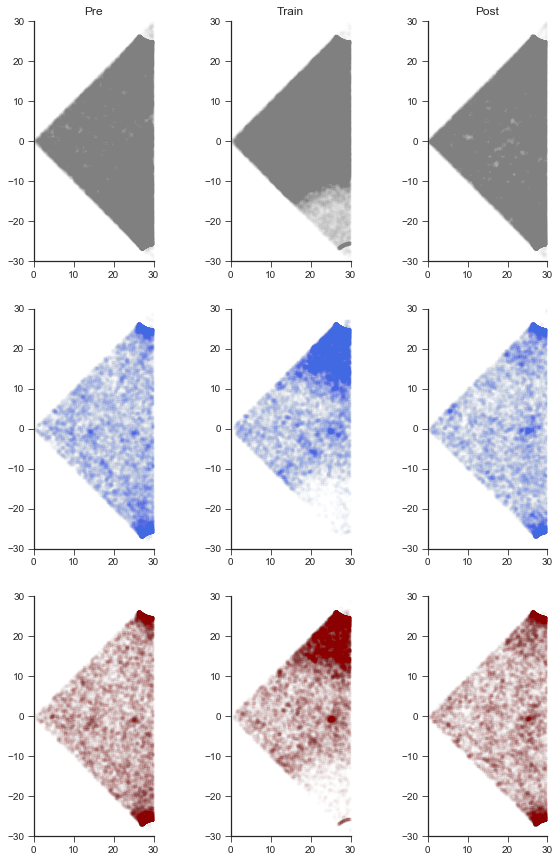

In [70]:
headfig, headaxs = plt.subplots(3,3,figsize=(10,15))
for tind, trial in enumerate(trialName):
    
    # movement points
    flyttdf = ttdf.query('trial=="'+trial+'" & transVelo>'+str(moveTH)+'')
    headaxs[0,tind].plot(flyttdf['xt'], flyttdf['yt'],'.', alpha=0.01, color='grey')
    
    # cw rot points
    flyttdf = ttdf.query('trial=="'+trial+'" & transVelo<='+str(moveTH)+' & rotVelo>'+str(rotTH)+'')
    headaxs[1,tind].plot(flyttdf['xt'], flyttdf['yt'],'.', alpha=0.01, color='royalblue')
    
    # ccw rot points
    flyttdf = ttdf.query('trial=="'+trial+'" & transVelo<='+str(moveTH)+' & rotVelo<'+str(-rotTH)+'')
    headaxs[2,tind].plot(flyttdf['xt'], flyttdf['yt'],'.', alpha=0.01, color='darkred')
    
    for i in range(3):
        myAxisTheme(headaxs[i,tind])
        headaxs[i,tind].set_xlim(0, 30)
        headaxs[i,tind].set_ylim(-30,30)
        headaxs[i,tind].set_aspect('equal')
        headaxs[0,tind].set_title(trialName[tind].capitalize(), fontsize=12)

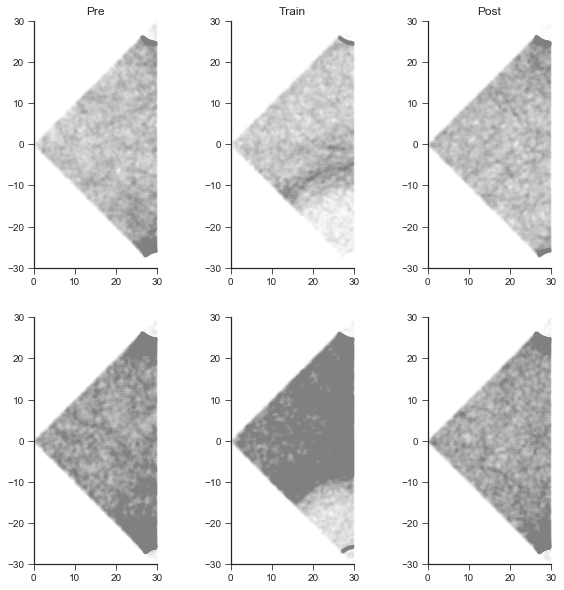

In [75]:
headfig, headaxs = plt.subplots(2,3,figsize=(10,10))
for tind, trial in enumerate(trialName):
    querystring = 'trial=="'+trial+'" & transVelo>'+str(moveTH)+''
    # movement points
    flyttdf = goodLearnDf.query(querystring)
    headaxs[0,tind].plot(flyttdf['xt'], flyttdf['yt'],'.', alpha=0.01, color='grey')
    
    flyttdf = badLearnDf.query(querystring)
    headaxs[1,tind].plot(flyttdf['xt'], flyttdf['yt'],'.', alpha=0.01, color='grey')
    
    for i in range(2):
        myAxisTheme(headaxs[i,tind])
        headaxs[i,tind].set_xlim(0, 30)
        headaxs[i,tind].set_ylim(-30,30)
        headaxs[i,tind].set_aspect('equal')
        headaxs[0,tind].set_title(trialName[tind].capitalize(), fontsize=12)

In [ ]:
numBins = [30,15]
range_vtr = [[-30, 30], [0, 30]]
extent_vtr = [0, 30,-30, 30]
headfig, headaxs = plt.subplots(2,3,figsize=(10,10))
for tind, trial in enumerate(trialName):
    
    querystring = 'trial=="'+trial+'" & transVelo>'+str(moveTH)+\
        ' & r_cone >'+str(6)+'& r_cyli >'+str(5)
    # rot points
    flyttdf = goodLearnDf.query(querystring)    
    H, xedg, yedg = np.histogram2d(flyttdf['yt'], flyttdf['xt'], bins=numBins, range=range_vtr)
    map2d = headaxs[0,tind].imshow(H/np.max(H), cmap='Greys', extent=extent_vtr, interpolation='nearest', 
                                     origin='lower', aspect=2, vmin=0, vmax=1)

    flyttdf = badLearnDf.query(querystring)
    H, xedg, yedg = np.histogram2d(flyttdf['yt'], flyttdf['xt'], bins=numBins, range=range_vtr)
    map2d = headaxs[1,tind].imshow(H/np.max(H), cmap='Greys', extent=extent_vtr, interpolation='nearest', 
                                     origin='lower', aspect=2, vmin=0, vmax=1)

    for i in range(2):
        myAxisTheme(headaxs[i,tind])
        headaxs[i,tind].set_xlim(0, 30)
        headaxs[i,tind].set_ylim(-30,30)
        headaxs[i,tind].set_aspect('equal')
        headaxs[0,tind].set_title(trialName[tind].capitalize(), fontsize=12)

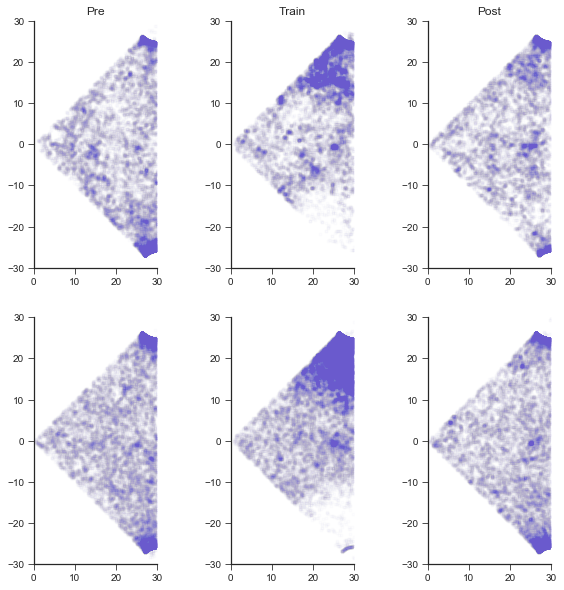

In [74]:
headfig, headaxs = plt.subplots(2,3,figsize=(10,10))
for tind, trial in enumerate(trialName):
    
    querystring = 'trial=="'+trial+'" & transVelo<='+str(moveTH)+\
        ' & ( rotVelo>'+str(rotTH)+'| rotVelo <'+str(-rotTH)+')'
    # rot points
    flyttdf = goodLearnDf.query(querystring)
    headaxs[0,tind].plot(flyttdf['xt'], flyttdf['yt'],'.', alpha=0.01, color='slateblue')

    flyttdf = badLearnDf.query(querystring)
    headaxs[1,tind].plot(flyttdf['xt'], flyttdf['yt'],'.', alpha=0.01, color='slateblue')
    
    for i in range(2):
        myAxisTheme(headaxs[i,tind])
        headaxs[i,tind].set_xlim(0, 30)
        headaxs[i,tind].set_ylim(-30,30)
        headaxs[i,tind].set_aspect('equal')
        headaxs[0,tind].set_title(trialName[tind].capitalize(), fontsize=12)

In [ ]:
numBins = [30,15]
range_vtr = [[-30, 30], [0, 30]]
extent_vtr = [0, 30,-30, 30]
headfig, headaxs = plt.subplots(2,3,figsize=(10,10))
for tind, trial in enumerate(trialName):
    
    querystring = 'trial=="'+trial+'" & transVelo<='+str(moveTH)+\
        ' & ( rotVelo>'+str(rotTH)+'| rotVelo <'+str(-rotTH)+') & r_cone >'+str(6)+'& r_cyli >'+str(5)
    # rot points
    flyttdf = goodLearnDf.query(querystring)    
    H, xedg, yedg = np.histogram2d(flyttdf['yt'], flyttdf['xt'], bins=numBins, range=range_vtr)
    map2d = headaxs[0,tind].imshow(H/np.max(H), cmap='Greys', extent=extent_vtr, interpolation='nearest', 
                                     origin='lower', aspect=2, vmin=0, vmax=1)

    flyttdf = badLearnDf.query(querystring)
    H, xedg, yedg = np.histogram2d(flyttdf['yt'], flyttdf['xt'], bins=numBins, range=range_vtr)
    map2d = headaxs[1,tind].imshow(H/np.max(H), cmap='Greys', extent=extent_vtr, interpolation='nearest', 
                                     origin='lower', aspect=2, vmin=0, vmax=1)

    for i in range(2):
        myAxisTheme(headaxs[i,tind])
        headaxs[i,tind].set_xlim(0, 30)
        headaxs[i,tind].set_ylim(-30,30)
        headaxs[i,tind].set_aspect('equal')
        headaxs[0,tind].set_title(trialName[tind].capitalize(), fontsize=12)

In [ ]:
numBins = [20,10]
range_vtr = [[-30, 30], [0, 30]]
extent_vtr = [0, 30,-30, 30]
headfig, headaxs = plt.subplots(2,3,figsize=(10,10))
for tind, trial in enumerate(trialName):
    querystring = 'trial=="'+trial+'" & transVelo>'+str(moveTH)+'& r_cone >'+str(10)+'& r_cyli >'+str(10)
    querystring2 = 'trial=="'+trial+'" & transVelo<='+str(moveTH)+\
        ' & ( rotVelo>'+str(rotTH)+'| rotVelo <'+str(-rotTH)+') & r_cone >'+str(10)+'& r_cyli >'+str(10)
    # rot points
    flyttdf = goodLearnDf.query(querystring) 
    flyttdf_turn = goodLearnDf.query(querystring2) 
    H, xedg, yedg = np.histogram2d(flyttdf['yt'], flyttdf['xt'], bins=numBins, range=range_vtr)
    H2, xedg2, yedg2 = np.histogram2d(flyttdf_turn['yt'], flyttdf_turn['xt'], bins=numBins, range=range_vtr)
    map2d = headaxs[0,tind].imshow(H2/H, cmap='Greys', extent=extent_vtr, interpolation='nearest', 
                                     origin='lower', aspect=2, vmin=0, vmax=3)

    flyttdf = badLearnDf.query(querystring)
    flyttdf_turn = badLearnDf.query(querystring2)
    H, xedg, yedg = np.histogram2d(flyttdf['yt'], flyttdf['xt'], bins=numBins, range=range_vtr)
    H2, xedg2, yedg2 = np.histogram2d(flyttdf_turn['yt'], flyttdf_turn['xt'], bins=numBins, range=range_vtr)
    map2d = headaxs[1,tind].imshow(H2/H, cmap='Greys', extent=extent_vtr, interpolation='nearest', 
                                     origin='lower', aspect=2, vmin=0, vmax=3)


    for i in range(2):
        myAxisTheme(headaxs[i,tind])
        headaxs[i,tind].set_xlim(0, 30)
        headaxs[i,tind].set_ylim(-30,30)
        headaxs[i,tind].set_aspect('equal')
        headaxs[0,tind].set_title(trialName[tind].capitalize(), fontsize=12)

### Residency ~ amount spent turning in hot, cool and BL zone

In [ ]:
headfig, headaxs = plt.subplots(3,3,figsize=(10,10))
trialLengths = [20*60*10., 20*60*20., 20*60*10.]
for tind, trial in enumerate(trialName):
    
    for fly in range(numFlies):
        
        querystring_bl = 'trial=="'+trial+'" & flyID=="'+flyIDs[fly]+\
        '" & r_cone >='+str(maxRdist)+ ' & r_cone <'+str(45)+\
        ' & r_cyli >='+str(maxRdist)+  '& r_cyli <'+str(45)
        
        querystring_hot = 'trial=="'+trial+'" & flyID=="'+flyIDs[fly]+'" & r_cyli <'+str(maxRdist)
        
        querystring_cool = 'trial=="'+trial+'" & flyID=="'+flyIDs[fly]+'" & r_cone <'+str(maxRdist)

        querystring2 = ' ( rotVelo>'+str(rotTH)+'| rotVelo <'+str(-rotTH)+') & transVelo<='+str(moveTH)

        #Good learners
        try:
            flyttdf = goodLearnDf.query(querystring_bl)
            flyttdf_turns = flyttdf.query(querystring2)

            headaxs[0,tind].plot(len(flyttdf['x'])/trialLengths[tind],len(flyttdf_turns['x'])/trialLengths[tind],
                               'o', markersize=8,  alpha=0.9, color='orange')
            
            flyttdf = goodLearnDf.query(querystring_hot)
            flyttdf_turns = flyttdf.query(querystring2)

            headaxs[1,tind].plot(len(flyttdf['x'])/trialLengths[tind],len(flyttdf_turns['x'])/trialLengths[tind],
                               'o', markersize=8,  alpha=0.9, color='firebrick')
            
            flyttdf = goodLearnDf.query(querystring_cool)
            flyttdf_turns = flyttdf.query(querystring2)

            headaxs[2,tind].plot(len(flyttdf['x'])/trialLengths[tind],len(flyttdf_turns['x'])/trialLengths[tind],
                               'o', markersize=8,  alpha=0.9, color='royalblue')
        
        except:
            pass
        
        # Bad learner
        try:
            flyttdf = badLearnDf.query(querystring_bl)
            flyttdf_turns = flyttdf.query(querystring2)

            headaxs[0,tind].plot(len(flyttdf['x'])/trialLengths[tind],len(flyttdf_turns['x'])/trialLengths[tind],
                               'o', markersize=7, alpha=0.5, color='grey')
            
            flyttdf = badLearnDf.query(querystring_hot)
            flyttdf_turns = flyttdf.query(querystring2)

            headaxs[1,tind].plot(len(flyttdf['x'])/trialLengths[tind],len(flyttdf_turns['x'])/trialLengths[tind],
                               'o', markersize=7, alpha=0.5, color='grey')
            
            flyttdf = badLearnDf.query(querystring_cool)
            flyttdf_turns = flyttdf.query(querystring2)

            headaxs[2,tind].plot(len(flyttdf['x'])/trialLengths[tind],len(flyttdf_turns['x'])/trialLengths[tind],
                               'o', markersize=7, alpha=0.5, color='grey')
        except:
            pass
            

    for i in range(3):
        myAxisTheme(headaxs[i,tind])
        headaxs[i,tind].set_xlim(-0.1, 1)
        headaxs[i,tind].set_ylim(-0.01,0.2)
    headaxs[0,tind].set_title(trialName[tind].capitalize(), fontsize=12)

In [ ]:
headfig, headaxs = plt.subplots(1,3,figsize=(10,3.5))
trialLengths = [20*60*10., 20*60*20., 20*60*10.]
for tind, trial in enumerate(trialName):
    
    for fly in range(numFlies):
        
        querystring_bl = 'trial=="'+trial+'" & flyID=="'+flyIDs[fly]+\
        '" & r_cone >='+str(maxRdist)+ ' & r_cone <'+str(45)+\
        ' & r_cyli >='+str(maxRdist)+  '& r_cyli <'+str(45)
        
        querystring_hot = 'trial=="'+trial+'" & flyID=="'+flyIDs[fly]+'" & r_cyli <'+str(maxRdist)
        
        querystring_cool = 'trial=="'+trial+'" & flyID=="'+flyIDs[fly]+'" & r_cone <'+str(maxRdist)

        querystring2 = ' ( rotVelo>'+str(rotTH)+'| rotVelo <'+str(-rotTH)+') & transVelo<='+str(moveTH)

        #All flies
        flyttdf = ttdf.query(querystring_bl)
        flyttdf_turns = flyttdf.query(querystring2)

        headaxs[tind].plot(len(flyttdf['x'])/trialLengths[tind],len(flyttdf_turns['x'])/trialLengths[tind],
                           'o', markersize=7,  alpha=0.9, color='orange')

        flyttdf = ttdf.query(querystring_hot)
        flyttdf_turns = flyttdf.query(querystring2)

        headaxs[tind].plot(len(flyttdf['x'])/trialLengths[tind],len(flyttdf_turns['x'])/trialLengths[tind],
                           'o', markersize=7,  alpha=0.9, color='firebrick')

        flyttdf = ttdf.query(querystring_cool)
        flyttdf_turns = flyttdf.query(querystring2)

        headaxs[tind].plot(len(flyttdf['x'])/trialLengths[tind],len(flyttdf_turns['x'])/trialLengths[tind],
                           'o', markersize=7,  alpha=0.9, color='royalblue')

    myAxisTheme(headaxs[tind])
    headaxs[tind].set_xlim(-0.1, 1)
    headaxs[tind].set_ylim(-0.01,0.2)
    headaxs[tind].set_title(trialName[tind].capitalize(), fontsize=12)

In [ ]:
headfig, headaxs = plt.subplots(1,3,figsize=(12,3.5))
trialLengths = [20*60*10., 20*60*20., 20*60*10.]
trialMarker = ['x','o']
zoneName = ['Baseline', 'Hot', 'Cool']
trialLengths = [20*60*10., 20*60*10.]
for tind, trial in enumerate([trialName[0],trialName[2]]):
    
    for fly in range(numFlies):
        
        querystring_bl = 'trial=="'+trial+'" & flyID=="'+flyIDs[fly]+\
        '" & r_cone >='+str(maxRdist)+ ' & r_cone <'+str(45)+\
        ' & r_cyli >='+str(maxRdist)+  '& r_cyli <'+str(45)
        
        querystring_hot = 'trial=="'+trial+'" & flyID=="'+flyIDs[fly]+'" & r_cyli <'+str(maxRdist)
        
        querystring_cool = 'trial=="'+trial+'" & flyID=="'+flyIDs[fly]+'" & r_cone <'+str(maxRdist)

        querystring2 = ' ( rotVelo>'+str(rotTH)+'| rotVelo <'+str(-rotTH)+') & transVelo<='+str(moveTH)

        #All flies
        flyttdf = ttdf.query(querystring_bl)
        flyttdf_turns = flyttdf.query(querystring2)

        headaxs[0].plot(len(flyttdf['x'])/trialLengths[tind],len(flyttdf_turns['x'])/trialLengths[tind],
                           marker=trialMarker[tind], markersize=7,  alpha=0.5, color='orange')

        flyttdf = ttdf.query(querystring_hot)
        flyttdf_turns = flyttdf.query(querystring2)

        headaxs[1].plot(len(flyttdf['x'])/trialLengths[tind],len(flyttdf_turns['x'])/trialLengths[tind],
                           marker=trialMarker[tind], markersize=7,  alpha=0.5, color='firebrick')

        flyttdf = ttdf.query(querystring_cool)
        flyttdf_turns = flyttdf.query(querystring2)

        headaxs[2].plot(len(flyttdf['x'])/trialLengths[tind],len(flyttdf_turns['x'])/trialLengths[tind],
                           marker=trialMarker[tind], markersize=7,  alpha=0.5, color='royalblue')

for i in range(3):
    myAxisTheme(headaxs[i])
    headaxs[i].set_xlim(-0.1, 1)
    headaxs[i].set_ylim(-0.01,0.2)
    headaxs[i].set_title(zoneName[i], fontsize=12)

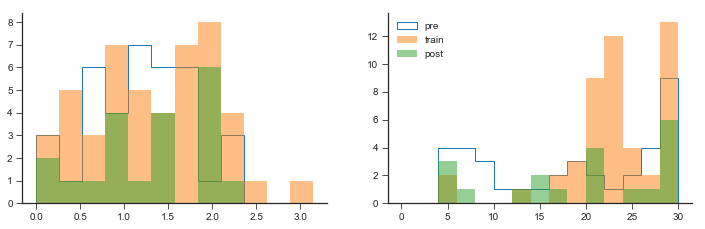

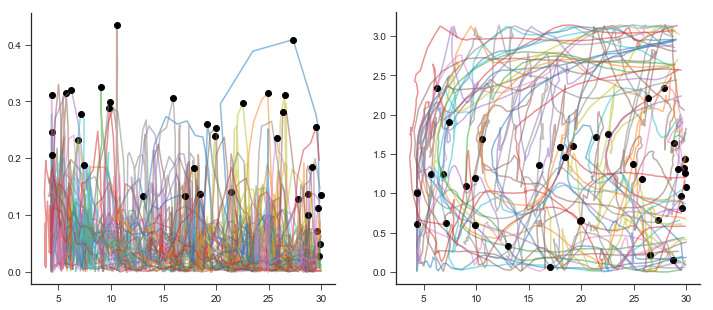

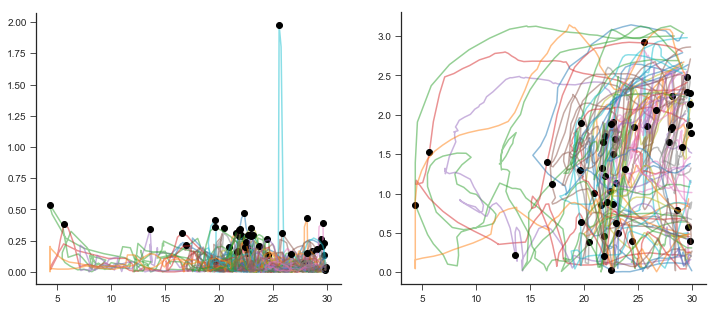

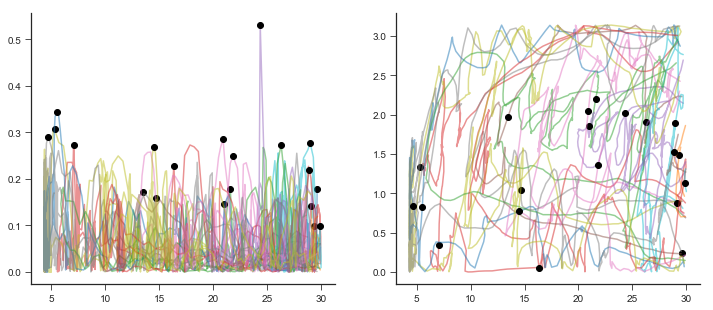

In [226]:
maxRdist = 30

headfig, headaxs = plt.subplots(1,2,figsize=(12,3.5))
for trial in trialName:
    flyttdf = ttdf.query('trial=="'+trial+'" & r_cyli<='+str(maxRdist)+' & flyID=="'+flyIDs[fly]+'"')
    fragmentSt = np.hstack((0,np.where(np.diff(flyttdf['time'])>2/20.)[0]))
    betaCyliFragList= []
    rCyliFragList= []

    reoriRad = []
    reoriBeta = []
    
    fig, axs = plt.subplots(1,2,figsize=(12,5))

    for i, fs in enumerate(fragmentSt[:-1]):
        if fragmentSt[i+1]-fs < 3: 
            continue
        betafrag = flyttdf['beta_cyli'].values[fs+1:fragmentSt[i+1]]
        rfrag = flyttdf['r_cyli'].values[fs+1:fragmentSt[i+1]]
        dbetafrag = abs(np.diff(betafrag))

        betaCyliFragList.append(betafrag)
        rCyliFragList.append(rfrag)

        axs[0].plot(rfrag[:-1], dbetafrag, alpha=0.5)

        axs[1].plot(rfrag,betafrag, alpha=0.5)

        #find max re-orientation
        reoriEv = np.argmax(dbetafrag)
        axs[0].plot(rfrag[reoriEv], dbetafrag[reoriEv],'ko')

        axs[1].plot(rfrag[reoriEv],betafrag[reoriEv],'ko')

        reoriRad.append(rfrag[reoriEv])
        reoriBeta.append(betafrag[reoriEv])

        #axs[1,0].plot(rfrag[reoriEv:-1], dbetafrag[reoriEv:], alpha=0.5)
        #axs[1,1].plot(rfrag[reoriEv:], betafrag[reoriEv:], alpha=0.5)

    if trial== "pre":
        headaxs[0].hist(reoriBeta, range=(0, np.pi), bins=12, histtype='step', stacked=True, fill=False);
        headaxs[1].hist(reoriRad, range=(0,maxRdist), bins=15, histtype='step', stacked=True, fill=False);
    else:
        headaxs[0].hist(reoriBeta, range=(0, np.pi), bins=12, alpha=0.5)#,histtype='step', stacked=True, fill=False);
        headaxs[1].hist(reoriRad, range=(0,maxRdist), bins=15, alpha=0.5)#,histtype='step', stacked=True, fill=False);
    
    for ax in headaxs: myAxisTheme(ax)
    for ax in axs: myAxisTheme(ax)
headaxs[1].legend(trialName)

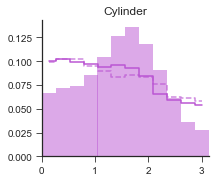

In [251]:
radExp = 30
angleBins = 12

fly=16
fig, axs = plt.subplots(1,1,figsize=(3,2.5))

# 1) Get training experience:
cond = trialName[1]

querystring = '(trial=="'+cond+'") & (r_cyli <='+str(radExp)+') & ( transVelo >'+str(2.0)+')' # (flyID=="' + flyIDs[fly] + '") &
flydf = ttdf.query(querystring)
distLM = flydf['r_cyli'].values.squeeze()
distLM[np.isnan(distLM)] = 100
entries,exits,visitT,entryTime,exitTime = countvisits(distLM[distLM<=radExp],visitRad)

# Experience heading distribtion:
n, ed = np.histogram(flydf['beta_cyli'].values.squeeze(),bins = np.linspace(0, np.pi,angleBins+1))
axs.bar(ed[1:]-np.pi/24, n/float(sum(n)), width=(np.pi/angleBins), 
                color=objColors[LM], alpha=0.5)

# 2) Compute heading angles of visits in post
cond = trialName[2]
querystring = '(trial=="'+cond+'") & (r_cyli <='+str(radExp)+') & ( transVelo >'+str(2.0)+')' # (flyID=="' + flyIDs[fly] + '") &
flydf = ttdf.query(querystring)
distLM = flydf['r_cyli'].values.squeeze()
distLM[np.isnan(distLM)] = 100
entries,exits,visitT,entryTime,exitTime = countvisits(distLM[distLM<=radExp],visitRad)

entryHeadings = flydf['beta_cyli'].values.squeeze()

m, ed = np.histogram(entryHeadings,bins = np.linspace(0, np.pi,angleBins+1))
axs.plot(ed[1:]-np.pi/24, m/float(sum(m)), color=objColors[LM], alpha=1, drawstyle='steps-mid')


# compute also for pre
# 2) Compute heading angles of visits in post
cond = trialName[0]
querystring = '(trial=="'+cond+'") & (r_cyli <='+str(radExp)+') & ( transVelo >'+str(2.0)+')' # (flyID=="' + flyIDs[fly] + '") &
flydf = ttdf.query(querystring)
distLM = flydf['r_cyli'].values.squeeze()
distLM[np.isnan(distLM)] = 100
entries,exits,visitT,entryTime,exitTime = countvisits(distLM[distLM<=radExp],visitRad)

entryHeadings = flydf['beta_cyli'].values.squeeze()

m, ed = np.histogram(entryHeadings,bins = np.linspace(0, np.pi,angleBins+1))
axs.plot(ed[1:]-np.pi/24, m/float(sum(m)), color=objColors[LM], alpha=0.7, linestyle='--', 
             drawstyle='steps-mid')

axs.set_xlim(0,np.pi)
axs.set_title(objNames[1])
myAxisTheme(axs)

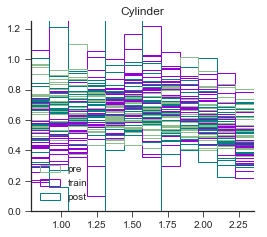

In [294]:
radExp = 30
angleBins = 12

fig, axs = plt.subplots(1,1,figsize=(4,3.5))
for fly in range(numFlies):
    for i, trial in enumerate(trialName):

        querystring = '(trial=="'+trial+'") & (r_cyli <='+str(radExp)+') & ( transVelo >'+str(2.0)+\
            ') &(flyID=="' + flyIDs[fly] + '")'
        flydf = ttdf.query(querystring)

        headRange = np.logical_and(flydf['beta_cyli'].values.squeeze() > np.pi/4, flydf['beta_cyli'].values.squeeze() < 3*np.pi/4)
        distLM = flydf['r_cyli'].values.squeeze()[headRange>0]
        distLM[np.isnan(distLM)] = 100
        entries,exits,visitT,entryTime,exitTime = countvisits(distLM,visitRad)

        # Experience heading distribtion:
        axs.hist(flydf['beta_cyli'].values.squeeze()[headRange>0],range=(np.pi/4, 3*np.pi/4), 
                 bins=12, histtype='step', stacked=True, fill=False, density=True, color=trialColors[i])

axs.set_xlim(np.pi/4, 3*np.pi/4)
axs.set_ylim(0, 1.25)
axs.set_title(objNames[1])
myAxisTheme(axs)
axs.legend(trialName, loc=3)

pre


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less_equal
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less_equal
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in less
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid valu

train
post


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in divide
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in divide


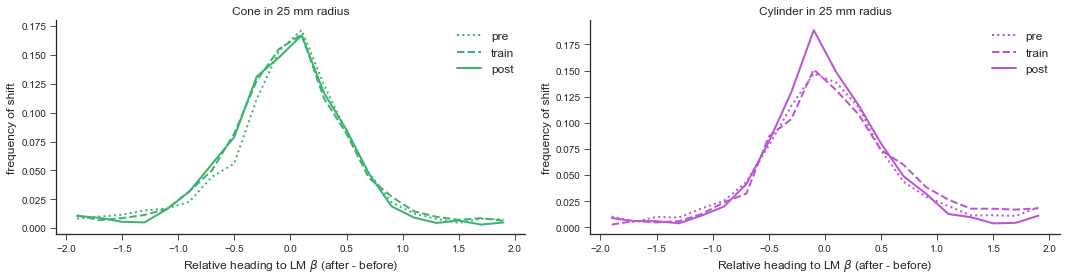

In [399]:
rmin = 15
rmax = 25

numBins = 20

headfig, headplt = plt.subplots(1,2, figsize=(15, 4))
ls = [':','--','-']

change_c = np.zeros((len(trialName), numBins))
change_l = np.zeros((len(trialName), numBins))
    
for tind, trial in enumerate(trialName):
    
    m_c = np.zeros((numFlies, numBins))
    m_l = np.zeros((numFlies, numBins))
    
    print(trial)
    for fly in range(numFlies):
        querystring = '(trial=="'+trial+'") & ( transVelo >'+str(2.0)+\
                ') &(flyID=="' + flyIDs[fly] + '")'
        flydf = ttdf.query(querystring)

        rt_l = flydf['r_cyli'].values.squeeze()
        rt_c = flydf['r_cone'].values.squeeze()
        bht_l = flydf['beta_cyli'].values.squeeze()
        bht_c = flydf['beta_cone'].values.squeeze()
        at = flydf['alphat'].values.squeeze()

        #     angular position vector gamma
        gt_l = flydf['gamma_cyli'].values.squeeze()
        gt_c = flydf['gamma_cone'].values.squeeze()

        # Compute masks for the zones close to the two landmarks
        C_visit_zone = np.logical_and(rt_c <= rmax,rt_c > rmin)
        L_visit_zone = np.logical_and(rt_l <= rmax,rt_l > rmin)

        # Map for reorientations (= change in beta)
        dbeta_c = np.hstack((0,np.diff(bht_c)))
        dbeta_l = np.hstack((0,np.diff(bht_l)))

        binIndex_Czones = np.logical_and(~np.isnan(dbeta_c), C_visit_zone)
        binIndex_Lzones = np.logical_and(~np.isnan(dbeta_l), L_visit_zone)

        # select for LM to side
        beginT_c = np.logical_and(binIndex_Czones, np.logical_and(bht_c > np.pi/4, bht_c < 3*np.pi/4))
        beginT_l = np.logical_and(binIndex_Lzones, np.logical_and(bht_l > np.pi/4, bht_l < 3*np.pi/4))

        action_c = []
        action_l = []

        dt = 10
        for i in np.where(beginT_c)[0][:-dt]:
            #action_c.append(bht_c[i+dt]-bht_c[i])
            action_c.append(at[i+dt]-at[i])
        for i in np.where(beginT_l)[0][:-dt]:
            #action_l.append(bht_l[i+dt]-bht_l[i])
            action_l.append(at[i+dt]-at[i])

        action_c = np.asarray(action_c)
        action_l = np.asarray(action_l)
        
        # plot
        m, ed = np.histogram(action_c[~np.isnan(action_c)], bins = np.linspace(-2,2,numBins+1))
        m_c[fly,:] = m/float(np.sum(m))
        m, ed = np.histogram(action_l[~np.isnan(action_l)], bins = np.linspace(-2,2,numBins+1))
        m_l[fly,:] = m/float(np.sum(m))
        
    change_c[tind, :] = np.nanmedian(m_c, axis=0).squeeze()
    change_l[tind, :] = np.nanmedian(m_l, axis=0).squeeze()
    
    edgs = ed[:-1] + np.diff(ed[:2])/2
    headplt[0].plot(edgs,change_c[tind,:], linewidth=2, color=objColors[0], linestyle=ls[tind], label=trial )
    headplt[1].plot(edgs,change_l[tind,:], linewidth=2, color=objColors[1], linestyle=ls[tind],label=trial )

    
for i,ax in enumerate(headplt):
    myAxisTheme(ax)
    ax.legend(fontsize=12)
    ax.set_title(objNames[i]+' in 25 mm radius',fontsize=12)
    #ax.set_xlim(0, np.pi)
    #ax.set_ylim(-0.025, 0.035)
    ax.set_xlabel(r'Relative heading to LM $\beta$ (after - before)', fontsize=12)
    ax.set_ylabel('frequency of shift',fontsize=12)

headfig.tight_layout()

## Does learning depend on #views with 2 landmarks (in hot or cold zone)?

In [28]:
ttdf.head()

flyID trial  rEvents  moving  transVelo   rotVelo      time         xt  \
0   m01   pre     10.0     0.0   0.000000  0.000000  0.000000  25.000000   
1   m01   pre     10.0     0.0   1.229863  0.000000  0.050006  25.000000   
2   m01   pre     10.0     1.0   7.441456 -0.078455  0.100011  25.000000   
3   m01   pre     10.0     1.0   4.333868 -0.863842  0.150017  25.049107   
4   m01   pre     10.0     1.0   2.442957 -0.314124  0.200022  25.066275   

         yt    alphat          r     gamma     r_cone  gamma_cone  beta_cone  \
0 -0.622000 -1.570793  25.007736 -0.024875  31.027518    1.408943   2.979736   
1 -0.622000 -1.570793  25.007736 -0.024875  31.027518    1.408943   2.979736   
2 -0.560500 -1.570793  25.006282 -0.022416  30.966824    1.408623   2.979416   
3 -0.191640 -1.566869  25.049840 -0.007650  30.594877    1.408261   2.975130   
4  0.024396 -1.523672  25.066287  0.000973  30.378915    1.407668   2.931340   

      r_cyli  gamma_cyli  beta_cyli  
0  29.800451    1.402216   0.168576  
1  29.800451    1.402216   0.168576  
2  29.861081    1.402562   0.168231  
3  30.216711    1.406208   0.160661  
4  30.427060    1.407928   0.115744

#### (1) Zones with 2 LM visible in principle

In [32]:
fogFar = 45
fogNear = 30
rZone = 25

gap = 122.0

trialtype = trialName[0]
fly = 16
querystring = '(trial=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'

singleFlyTrialdf = ttdf.query(querystring)

r_c = singleFlyTrialdf['r_cone'].values.squeeze()
r_z = singleFlyTrialdf['r_cyli'].values.squeeze()
at = singleFlyTrialdf['alphat'].values.squeeze()
g_c = singleFlyTrialdf['gamma_cone'].values.squeeze()
g_z = singleFlyTrialdf['gamma_cyli'].values.squeeze()
time = singleFlyTrialdf['time'].values.squeeze()

In [33]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # 2 LM visible:
    twoVisZone = np.logical_and(r_c < fogFar, r_z < fogFar)

    # cool + 2 LM visible:
    cool2VisZone = np.logical_and(r_c < rZone, r_z < fogFar)

    # hot + 2 LM visible:
    hot2VisZone = np.logical_and(r_c < fogFar, r_z < rZone)

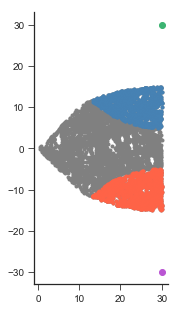

In [34]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.plot(singleFlyTrialdf['xt'].values.squeeze()[twoVisZone],
         singleFlyTrialdf['yt'].values.squeeze()[twoVisZone],'.', color='grey')
axs.plot(singleFlyTrialdf['xt'].values.squeeze()[hot2VisZone],
         singleFlyTrialdf['yt'].values.squeeze()[hot2VisZone],'.', color='tomato')
axs.plot(singleFlyTrialdf['xt'].values.squeeze()[cool2VisZone],
         singleFlyTrialdf['yt'].values.squeeze()[cool2VisZone],'.',color='steelblue')
axs.plot(conePos[0], conePos[1],'o',color=objColors[0])
axs.plot(cyliPos[0], cyliPos[1],'o',color=objColors[1])
axs.set_aspect('equal')
myAxisTheme(axs)

#### (2) Visibility of two landmarks at each position

In [35]:
twoVisibleAng = np.zeros(len(at))

for i in range(len(at)):
    gz = np.pi/2-gamma_cyli[i]
    gc = np.pi/2-gamma_cone[i]
    
    if at[i] >=0: # positive alpha_t
        if ( at[i] < gz - np.pi*(gap/2)/180.) or (at[i] > gz + np.pi*(gap/2)/180.):
            twoVisibleAng[i] = 1
    else: # negative alpha_t
        if ( at[i] > - gc + np.pi*(gap/2)/180.) or (at[i] < -gc - np.pi*(gap/2)/180.):
            twoVisibleAng[i] = 1
            
twoVisibleAng = twoVisibleAng.astype('bool')

In [36]:
twoVisible = np.logical_and(twoVisibleAng, twoVisZone)

twoVisibleHot = np.logical_and(twoVisibleAng, hot2VisZone)

twoVisibleCool = np.logical_and(twoVisibleAng, cool2VisZone)

#### (3) For all flies: correlated with learning performance (preference shift)

In [37]:
fogFar = 45
fogNear = 30
rZone = 24

gap = 122.0

trialtype = trialName[1]

time2Visible = np.zeros((len(trialName), numFlies))
time2VisibleHot = np.zeros((len(trialName),numFlies))
time2VisibleCool = np.zeros((len(trialName),numFlies))

for tind, trial in enumerate(trialName):
    for fly in range(numFlies):
        querystring = '(trial=="' + trial + '") & (flyID == "'+flyIDs[fly]+'")'

        singleFlyTrialdf = ttdf.query(querystring)

        r_c = singleFlyTrialdf['r_cone'].values.squeeze()
        r_z = singleFlyTrialdf['r_cyli'].values.squeeze()
        at = singleFlyTrialdf['alphat'].values.squeeze()
        g_c = singleFlyTrialdf['gamma_cone'].values.squeeze()
        g_z = singleFlyTrialdf['gamma_cyli'].values.squeeze()
        time = singleFlyTrialdf['time'].values.squeeze()

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            # 2 LM visible:
            twoVisZone = np.logical_and(r_c < fogFar, r_z < fogFar)

            # cool + 2 LM visible:
            cool2VisZone = np.logical_and(r_c < rZone, r_z < fogFar)

            # hot + 2 LM visible:
            hot2VisZone = np.logical_and(r_c < fogFar, r_z < rZone)


        twoVisibleAng = np.zeros(len(at))

        for i in range(len(at)):
            gz = np.pi/2-g_z[i]
            gc = np.pi/2-g_c[i]

            if at[i] >=0: # positive alpha_t
                if ( at[i] < gz - np.pi*(gap/2)/180.) or (at[i] > gz + np.pi*(gap/2)/180.):
                    twoVisibleAng[i] = 1
            else: # negative alpha_t
                if ( at[i] > - gc + np.pi*(gap/2)/180.) or (at[i] < -gc - np.pi*(gap/2)/180.):
                    twoVisibleAng[i] = 1

        twoVisibleAng = twoVisibleAng.astype('bool')

        twoVisible = np.logical_and(twoVisibleAng, twoVisZone)

        twoVisibleHot = np.logical_and(twoVisibleAng, hot2VisZone)

        twoVisibleCool = np.logical_and(twoVisibleAng, cool2VisZone)

        time2Visible[tind,fly] = 100.0*sum(twoVisible)/len(twoVisible)
        time2VisibleHot[tind,fly] = 100.0*sum(twoVisibleHot)/len(twoVisibleHot)
        time2VisibleCool[tind,fly] = 100.0*sum(twoVisibleCool)/len(twoVisibleCool)

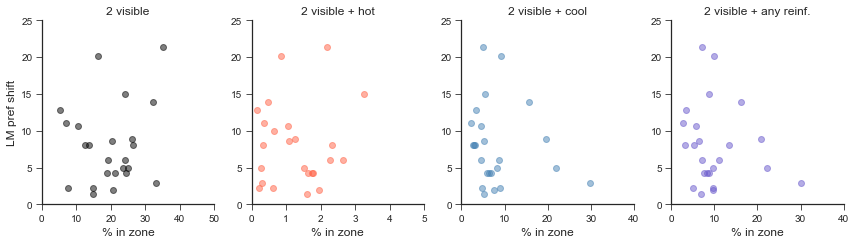

In [45]:
shiftEffect = np.sqrt(np.square(coneVisitCount[:,2]-coneVisitCount[:,0]) +\
                 np.square(cyliVisitCount[:,2]-cyliVisitCount[:,0]))
#coneVisitCount[:,2]-coneVisitCount[:,0]#
#coneVisitCount[:,2]-cyliVisitCount[:,2]

trial = 1
fig, axs = plt.subplots(1,4,figsize=(12,3.5))
axs[0].plot(time2Visible[trial,:], shiftEffect,'o', color='black', alpha=0.5)
axs[1].plot(time2VisibleHot[trial,:], shiftEffect,'o', color='tomato', alpha=0.5)
axs[2].plot(time2VisibleCool[trial,:], shiftEffect,'o', color='steelblue', alpha=0.5)
axs[3].plot(time2VisibleCool[trial,:]+time2VisibleHot[trial,:], shiftEffect,'o', color='slateblue', alpha=0.5)

titlestr = ['2 visible','2 visible + hot','2 visible + cool','2 visible + any reinf.']
upperxlim = [50, 5, 40, 40] #[50, 10, 10, 20] #
for i, ax in enumerate(axs):
    myAxisTheme(ax)
    ax.set_title(titlestr[i], fontsize=12)
    ax.set_xlabel('% in zone', fontsize=12)
    if i==0: ax.set_ylabel('LM pref shift', fontsize=12)
    ax.set_xlim(0,upperxlim[i])
    ax.set_ylim(0,25)
    
fig.tight_layout()

fig.savefig(analysisDir + 'headingAnalysis'+sep + genotype + '_' + flyIDs[0][0]
         +'_twoVisibleAnalysis_predict-shiftEffect_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

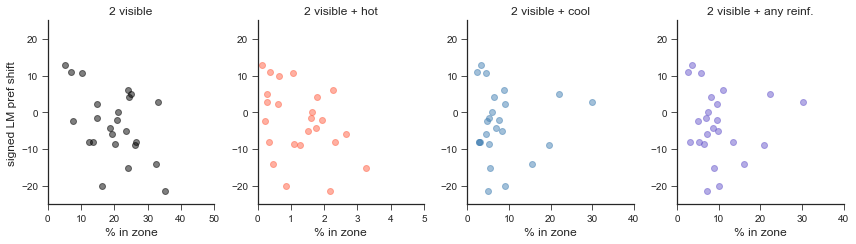

In [43]:
signedShiftEffect = shiftEffect*np.sign((coneVisitCount[:,2]+cyliVisitCount[:,2])-\
                                  (coneVisitCount[:,0]+cyliVisitCount[:,0]))

trial = 1
fig, axs = plt.subplots(1,4,figsize=(12,3.5))
axs[0].plot(time2Visible[trial,:], signedShiftEffect,'o', color='black', alpha=0.5)
axs[1].plot(time2VisibleHot[trial,:], signedShiftEffect,'o', color='tomato', alpha=0.5)
axs[2].plot(time2VisibleCool[trial,:], signedShiftEffect,'o', color='steelblue', alpha=0.5)
axs[3].plot(time2VisibleCool[trial,:]+time2VisibleHot[trial,:], signedShiftEffect,'o', color='slateblue', alpha=0.5)

titlestr = ['2 visible','2 visible + hot','2 visible + cool','2 visible + any reinf.']
upperxlim = [50, 5, 40, 40] #[50, 10, 10, 20] #excludes 1 pt in 2nd-4th plot
for i, ax in enumerate(axs):
    myAxisTheme(ax)
    ax.set_title(titlestr[i], fontsize=12)
    ax.set_xlabel('% in zone', fontsize=12)
    if i==0: ax.set_ylabel('signed LM pref shift', fontsize=12)
    ax.set_xlim(0,upperxlim[i])
    ax.set_ylim(-25,25)
    
fig.tight_layout()

fig.savefig(analysisDir + 'headingAnalysis'+sep + genotype + '_' + flyIDs[0][0]
         +'_twoVisibleAnalysis_predict-signedShiftEffect_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

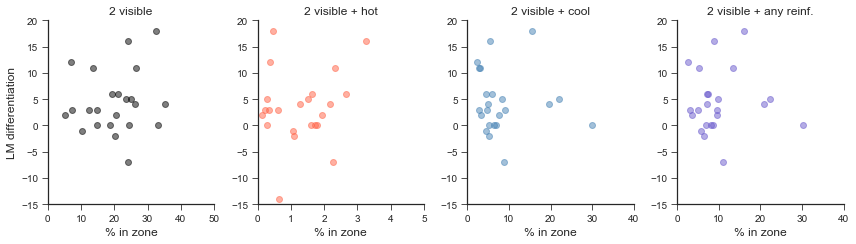

In [44]:
differentiation = (coneVisitCount[:,2]-coneVisitCount[:,0]) -\
                (cyliVisitCount[:,2]-cyliVisitCount[:,0])

fig, axs = plt.subplots(1,4,figsize=(12,3.5))
axs[0].plot(time2Visible[trial,:], differentiation,'o', color='black', alpha=0.5)
axs[1].plot(time2VisibleHot[trial,:], differentiation,'o', color='tomato', alpha=0.5)
axs[2].plot(time2VisibleCool[trial,:], differentiation,'o', color='steelblue', alpha=0.5)
axs[3].plot(time2VisibleCool[trial,:]+time2VisibleHot[trial,:], differentiation,'o', color='slateblue', alpha=0.5)

titlestr = ['2 visible','2 visible + hot','2 visible + cool','2 visible + any reinf.']
upperxlim = [50, 5, 40, 40] #[50, 10, 10, 20] #excludes 1 pt in 2nd-4th plot
for i, ax in enumerate(axs):
    myAxisTheme(ax)
    ax.set_title(titlestr[i], fontsize=12)
    ax.set_xlabel('% in zone', fontsize=12)
    if i==0: ax.set_ylabel('LM differentiation', fontsize=12)
    ax.set_xlim(0,upperxlim[i])
    ax.set_ylim(-15,20)
    
fig.tight_layout()

fig.savefig(analysisDir + 'headingAnalysis'+sep + genotype + '_' + flyIDs[0][0]
         +'_twoVisibleAnalysis_predict-differentiation_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

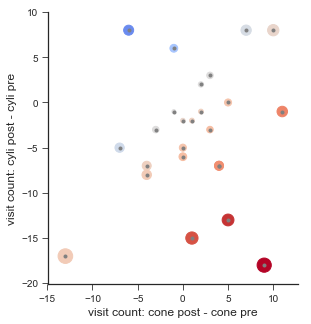

In [41]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.plot(coneVisitCount[:,2]-coneVisitCount[:,0],
            cyliVisitCount[:,2]-cyliVisitCount[:,0],'.',color='grey')
axs.scatter(coneVisitCount[:,2]-coneVisitCount[:,0],
            cyliVisitCount[:,2]-cyliVisitCount[:,0],
           s=shiftEffect*10, c=differentiation, vmin=-20, vmax=20, cmap='coolwarm')
axs.set_aspect('equal')
axs.set_xlabel('visit count: cone post - cone pre', fontsize=12)
axs.set_ylabel('visit count: cyli post - cyli pre', fontsize=12)
myAxisTheme(axs)

fig.savefig(analysisDir + 'headingAnalysis'+sep + genotype + '_' + flyIDs[0][0]
         +'_twoVisibleAnalysis_shiftEffectAndDifferntiation_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

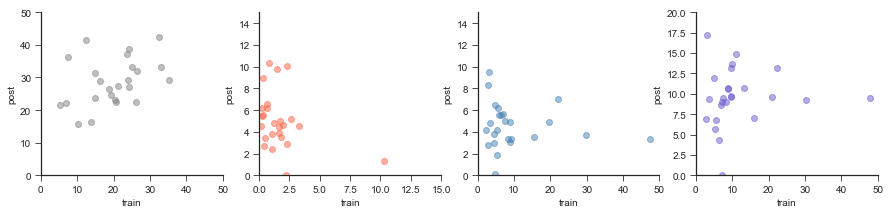

In [42]:
fig, axs = plt.subplots(1,4,figsize=(15,3))
axs[0].plot(time2Visible[1,:], time2Visible[2,:],'o', color='grey', alpha=0.5)
axs[1].plot(time2VisibleHot[1,:], time2VisibleHot[2,:],'o', color='tomato', alpha=0.5)
axs[2].plot(time2VisibleCool[1,:], time2VisibleCool[2,:],'o', color='steelblue', alpha=0.5)
axs[3].plot(time2VisibleCool[1,:]+time2VisibleHot[1,:], 
            time2VisibleCool[2,:]+time2VisibleHot[2,:],'o', color='slateblue', alpha=0.5)
upperxlim = [50, 15, 50, 50]
upperylim = [50, 15, 15, 20]
for i, ax in enumerate(axs):
    myAxisTheme(ax)
    ax.set_xlabel('train')
    ax.set_ylabel('post')
    ax.set_xlim(0,upperxlim[i])
    ax.set_ylim(0,upperylim[i])

#### (4) Check if positions/views have any predictive power for learning performance

In [62]:
import statsmodels.api as sm

predDf = pd.DataFrame(data={'time2vis':time2Visible[1,:],
                            'time2visHot':time2VisibleHot[1,:],
                            'time2visCool':time2VisibleCool[1,:]})

target = pd.DataFrame(data={'signedShiftEffect':signedShiftEffect,
                            'differentiation':differentiation})

In [63]:
Y = target['signedShiftEffect']

model = sm.OLS(Y, predDf['time2visHot']).fit()
predictions = model.predict(predDf['time2visHot']) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      signedShiftEffect   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     4.053
Date:                Tue, 17 Apr 2018   Prob (F-statistic):             0.0554
Time:                        12:57:46   Log-Likelihood:                -90.121
No. Observations:                  25   AIC:                             182.2
Df Residuals:                      24   BIC:                             183.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
time2visHot    -1.4332      0.712     -2.013      0.055      -2.902       0.036
==============================================================================
Omnibus:                        1.026   Durbin-Watson:                   2.352
Prob(Omnibus):                  0.599   Jarque-Bera (JB):                1.003
Skew:                          -0.386   Prob(JB):                        0.606
Kurtosis:                       2.395   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
Y = target['differentiation']

model = sm.OLS(Y, predDf['time2visHot']).fit()
predictions = model.predict(predDf['time2visHot']) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        differentiation   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     5.514
Date:                Tue, 17 Apr 2018   Prob (F-statistic):             0.0274
Time:                        12:58:03   Log-Likelihood:                -88.474
No. Observations:                  25   AIC:                             178.9
Df Residuals:                      24   BIC:                             180.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
time2visHot     1.5652      0.667      2.348      0.027       0.190       2.941
==============================================================================
Omnibus:                        7.330   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                5.529
Skew:                           0.803   Prob(JB):                       0.0630
Kurtosis:                       4.651   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
Y = target['signedShiftEffect']

model = sm.OLS(Y, predDf['time2visCool']).fit()
predictions = model.predict(predDf['time2visCool']) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      signedShiftEffect   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                   0.03363
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.856
Time:                        12:58:06   Log-Likelihood:                -92.054
No. Observations:                  25   AIC:                             186.1
Df Residuals:                      24   BIC:                             187.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
time2visCool    -0.0256      0.139     -0.183      0.856      -0.313       0.262
==============================================================================
Omnibus:                        0.485   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.785   Jarque-Bera (JB):                0.600
Skew:                          -0.163   Prob(JB):                        0.741
Kurtosis:                       2.315   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
Y = target['differentiation']

model = sm.OLS(Y, predDf['time2visCool']).fit()
predictions = model.predict(predDf['time2visCool']) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        differentiation   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                    0.2882
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.596
Time:                        12:58:16   Log-Likelihood:                -90.910
No. Observations:                  25   AIC:                             183.8
Df Residuals:                      24   BIC:                             185.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
time2visCool     0.0715      0.133      0.537      0.596      -0.203       0.346
==============================================================================
Omnibus:                        4.039   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                2.603
Skew:                           0.306   Prob(JB):                        0.272
Kurtosis:                       4.457   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
from sklearn import linear_model

lm = linear_model.LinearRegression()

y = target['differentiation']
X = predDf

model = lm.fit(X, y)

predictions = lm.predict(predDf)
print(predictions)

lm.score(X,y)

[ 4.65319801  4.93205426  2.09771388  6.14024146 -6.57651602  5.86829326
  5.50576364  1.80944539  6.30436937  6.55938298  4.7588963   4.64936115
  6.91684548  0.87889231  5.24596778  6.14421861  6.13628457  5.45113161
  5.27517159 -1.40626614  5.42495711  5.2278141   9.65045767  6.37207854
  5.98024307]


0.15108070967556064